In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Imports & Global Config

import os
import random
from collections import Counter

import numpy as np
import pandas as pd

# Reproducibility
RANDOM_SEED = 42

def set_global_seed(seed: int = RANDOM_SEED) -> None:
    """
    Set random seeds for Python, NumPy (and later PyTorch if needed)
    to make experiments as reproducible as possible.
    """
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        # PyTorch might not be imported yet; that's fine.
        pass

set_global_seed(RANDOM_SEED)

# Pandas display options
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 200)
pd.set_option("display.max_rows", 20)

print("[Setup] Imports loaded and global seed set to", RANDOM_SEED)


[Setup] Imports loaded and global seed set to 42


In [ ]:
# Load CTU & InSDN + Integrity Report

# -->Paths
CTU_PATH = "/content/drive/MyDrive/Datasets/CTU13/CTU13_new_balanced_v2.csv"      # این مسیر را با فایل CTU خودت عوض کن
INSDN_PATH = "/content/drive/MyDrive/Datasets/InSDN/InSDN_Botnet_Final.csv"  # این مسیر را با فایل InSDN خودت عوض کن

for path, name in [(CTU_PATH, "CTU"), (INSDN_PATH, "InSDN")]:
    if not os.path.isfile(path):
        raise FileNotFoundError(
            f"[ERROR] {name} file not found at: {path}\n"
            f" → لطفاً مسیر {name} را در Cell 2 تنظیم کن."
        )

print(f"[Load] Reading CTU from: {CTU_PATH}")
ctu_raw = pd.read_csv(CTU_PATH)

print(f"[Load] Reading InSDN from: {INSDN_PATH}")
insdn_raw = pd.read_csv(INSDN_PATH)

print(f"\n[Load] CTU raw shape : {ctu_raw.shape}")
print(f"[Load] InSDN raw shape: {insdn_raw.shape}")


#Helper: basic integrity report
def integrity_report(df: pd.DataFrame, name: str) -> None:
    """
    Print a compact integrity report:
    - number of columns
    - total missing values
    - total infinite values (numeric cols only)
    """
    n_cols = df.shape[1]
    n_missing = int(df.isna().sum().sum())
    numeric_df = df.select_dtypes(include=[np.number])
    n_infinite = int(np.isinf(numeric_df.to_numpy()).sum()) if not numeric_df.empty else 0

    print(f"\n[{name}] Integrity")
    print(f"  columns: {n_cols}")
    print(f"  missing values (total): {n_missing}")
    print(f"  infinite values (numeric only): {n_infinite}")


integrity_report(ctu_raw, "CTU")
integrity_report(insdn_raw, "InSDN")


# Helper: label distribution with percentages
def label_distribution(
    y: pd.Series,
    name: str,
    positive_label: int = 1,
    negative_label: int = 0
) -> None:
    """
    Print distribution of a binary label column with absolute counts and percentages.
    """
    counter = Counter(y)
    total = len(y)
    print(f"\n[Labels] {name} y distribution:")
    for lbl, cnt in sorted(counter.items()):
        pct = 100.0 * cnt / total if total > 0 else 0.0
        print(f"  label {lbl}: {cnt} ({pct:.4f}%)")
    if positive_label in counter and negative_label in counter:
        pos, neg = counter[positive_label], counter[negative_label]
        if pos > 0:
            ratio = neg / pos
            print(f"  benign:attack ratio ≈ {neg}:{pos} ≈ {ratio:.1f}:1")
        else:
            print("  [WARN] No positive samples found; cannot compute ratio.")


# Binary labels (CTU & InSDN)
LABEL_COL = "Binary_Label"

if LABEL_COL not in ctu_raw.columns:
    raise KeyError(f"[CTU] Expected binary label column '{LABEL_COL}' not found in CTU columns.")
if LABEL_COL not in insdn_raw.columns:
    raise KeyError(f"[InSDN] Expected binary label column '{LABEL_COL}' not found in InSDN columns.")

label_distribution(ctu_raw[LABEL_COL], "CTU")
label_distribution(insdn_raw[LABEL_COL], "InSDN")


# CTU: botnet families & scenarios
if "botnet_family" in ctu_raw.columns:
    fam_counts = ctu_raw["botnet_family"].value_counts().to_dict()
    print("\n[CTU] Family column detected: botnet_family")
    print(f"[CTU] Top families: {fam_counts}")
else:
    print("\n[CTU] botnet_family column NOT found.")

if "scenario" in ctu_raw.columns:
    n_unique_scenarios = ctu_raw["scenario"].nunique()
    print(f"\n[CTU] Scenario/capture column detected: scenario")
    print(f"[CTU] #unique scenarios: {n_unique_scenarios}")
else:
    print("\n[CTU] scenario column NOT found.")


# InSDN: gid + 5-tuple presence
if "gid" in insdn_raw.columns:
    print(f"\n[InSDN] gid present: True")
    print(f"[InSDN] #unique gid: {insdn_raw['gid'].nunique()}")
else:
    print("\n[InSDN] gid present: False")

five_tuple_cols = ["Src IP", "Dst IP", "Src Port", "Dst Port", "Protocol"]
has_5tuple = all(col in insdn_raw.columns for col in five_tuple_cols)

print(f"[InSDN] Has 5-tuple fields (Src/Dst IP/Port + Protocol): {has_5tuple}")
if has_5tuple:
    print("[InSDN] 5-tuple fields OK.")
else:
    missing_5tuple = [c for c in five_tuple_cols if c not in insdn_raw.columns]
    print(f"[InSDN] Missing 5-tuple columns: {missing_5tuple}")


# Final shapes (for sanity)
print(f"\n[Final] CTU shape : {ctu_raw.shape}")
print(f"[Final] InSDN shape: {insdn_raw.shape}")


[Load] Reading CTU from: /content/drive/MyDrive/Datasets/CTU13/CTU13_new_balanced_v2.csv
[Load] Reading InSDN from: /content/drive/MyDrive/Datasets/InSDN/InSDN_Botnet_Final.csv

[Load] CTU raw shape : (787719, 20)
[Load] InSDN raw shape: (68588, 86)

[CTU] Integrity
  columns: 20
  missing values (total): 1159268
  infinite values (numeric only): 0

[InSDN] Integrity
  columns: 86
  missing values (total): 0
  infinite values (numeric only): 0

[Labels] CTU y distribution:
  label 0: 525146 (66.6667%)
  label 1: 262573 (33.3333%)
  benign:attack ratio ≈ 525146:262573 ≈ 2.0:1

[Labels] InSDN y distribution:
  label 0: 68424 (99.7609%)
  label 1: 164 (0.2391%)
  benign:attack ratio ≈ 68424:164 ≈ 417.2:1

[CTU] Family column detected: botnet_family
[CTU] Top families: {'Benign': 525146, 'Neris': 210070, 'Rbot': 25142, 'Virut': 21236, 'Menti': 2667, 'NsisAy': 2000, 'Murlo': 1395, 'Sogou': 63}

[CTU] Scenario/capture column detected: scenario
[CTU] #unique scenarios: 1373

[InSDN] gid prese

In [ ]:
# Leakage-safe feature sets & common features

ctu = ctu_raw.copy()
ins = insdn_raw.copy()

print("[Info] Working copies created: 'ctu' and 'ins'.")


LABEL_COL = "Binary_Label"
assert LABEL_COL in ctu.columns,  "[CTU] Binary_Label not found."
assert LABEL_COL in ins.columns,  "[InSDN] Binary_Label not found."

CTU_META_SUSPICIOUS = [
    LABEL_COL,
    "botnet_family",
    "capture_family",
    "scenario",
    "scenario_id",
    "scenario_type",
    "ctu_group",
    "ctu_group_v2",
    "attack_profile",
    "benign_profile",
    "scenario_key",
]


CTU_META_SUSPICIOUS = [c for c in CTU_META_SUSPICIOUS if c in ctu.columns]

INSDN_ID_SUSPICIOUS = [
    LABEL_COL,
    "Label",        # Normal / BOTNET
    "Flow ID",
    "gid",
    "Timestamp",
    "Src IP",
    "Dst IP",
    "Src Port",
    "Dst Port",
    "Protocol",
]

INSDN_ID_SUSPICIOUS = [c for c in INSDN_ID_SUSPICIOUS if c in ins.columns]


print("\n[CTU] Suspicious/meta columns (excluded from features):")
print(" ", CTU_META_SUSPICIOUS)

print("\n[InSDN] Suspicious/ID columns (excluded from features):")
print(" ", INSDN_ID_SUSPICIOUS)


# Select only the numerical columns for the model (from both datasets).

ctu_numeric_cols = ctu.select_dtypes(include=[np.number]).columns.tolist()
ins_numeric_cols = ins.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n[CTU] #numeric columns: {len(ctu_numeric_cols)}")
print(f"[InSDN] #numeric columns: {len(ins_numeric_cols)}")


# Define safe features (numeric & without suspicious columns).

ctu_safe_features = [c for c in ctu_numeric_cols if c not in CTU_META_SUSPICIOUS]
ins_safe_features = [c for c in ins_numeric_cols if c not in INSDN_ID_SUSPICIOUS]

print(f"\n[CTU] #safe numeric features (candidate model inputs): {len(ctu_safe_features)}")
print("[CTU] Example safe features:", ctu_safe_features[:10])

print(f"\n[InSDN] #safe numeric features (candidate model inputs): {len(ins_safe_features)}")
print("[InSDN] Example safe features:", ins_safe_features[:10])


# Intersection of safe features between CTU and InSDN

common_safe_features = sorted(list(set(ctu_safe_features).intersection(ins_safe_features)))

print(f"\n[Common] #common safe numeric features between CTU & InSDN: {len(common_safe_features)}")
print("[Common] Features:", common_safe_features)

if len(common_safe_features) < 5:
    print("\n[WARN] Very few common numeric features between CTU & InSDN.")
    print("       ممکن است برای cross-domain pretraining نیاز به استراتژی دیگری داشته باشیم (مثلاً استفاده از تمام safe_features هر دامنه به‌صورت جداگانه).")


# Save the feature names for use in later cells.

CTU_SAFE_FEATURES = ctu_safe_features
INSDN_SAFE_FEATURES = ins_safe_features
COMMON_SAFE_FEATURES = common_safe_features

print("\n[Done] Feature lists stored as:")
print("  CTU_SAFE_FEATURES  (len =", len(CTU_SAFE_FEATURES), ")")
print("  COMMON_SAFE_FEATURES (len =", len(COMMON_SAFE_FEATURES), ")")


[Info] Working copies created: 'ctu' and 'ins'.

[CTU] Suspicious/meta columns (excluded from features):
  ['Binary_Label', 'botnet_family', 'capture_family', 'scenario', 'scenario_id', 'scenario_type', 'ctu_group', 'ctu_group_v2', 'attack_profile', 'benign_profile', 'scenario_key']

[InSDN] Suspicious/ID columns (excluded from features):
  ['Binary_Label', 'Label', 'Flow ID', 'gid', 'Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port', 'Protocol']

[CTU] #numeric columns: 7
[InSDN] #numeric columns: 80

[CTU] #safe numeric features (candidate model inputs): 6
[CTU] Example safe features: ['dur', 'stos', 'dtos', 'tot_pkts', 'tot_bytes', 'src_bytes']

[InSDN] #safe numeric features (candidate model inputs): 76
[InSDN] Example safe features: ['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean']

[Common] #common safe numeric features between CTU & InSDN: 0
[Common] Features: []



In [ ]:
# Harmonized cross-domain numeric features

print("[Step] Building harmonized CTU/InSDN features for cross-domain learning...")


#Define the conceptual column mapping

# Columns in InSDN that are comparable to CTU
INSDN_EQUIV_COLS = {
    "dur": "Flow Duration",  # Flow duration
    # Total packet count in CTU ≈ sum of Fwd/Bwd in InSDN
    "tot_pkts": ("Tot Fwd Pkts", "Tot Bwd Pkts"),
    # Total bytes in CTU ≈ sum of Fwd/Bwd byte lengths in InSDN
    "tot_bytes": ("TotLen Fwd Pkts", "TotLen Bwd Pkts"),
    # src_bytes in CTU ≈ Fwd bytes in InSDN (approximately)
    "src_bytes": "Subflow Fwd Byts",
    # We construct dst_bytes in both datasets:
      # - In CTU: tot_bytes - src_bytes
      # - In InSDN: Subflow Bwd Byts
    "dst_bytes": "Subflow Bwd Byts",
}

# Check for the existence of equivalent columns in InSDN
missing_insdn = []
for k, v in INSDN_EQUIV_COLS.items():
    if isinstance(v, tuple):
        for sub in v:
            if sub not in ins.columns:
                missing_insdn.append(sub)
    else:
        if v not in ins.columns:
            missing_insdn.append(v)

if missing_insdn:
    raise KeyError(
        "[ERROR] The following expected columns are missing in InSDN for harmonization:\n"
        f"  {missing_insdn}\n"
        "لطفاً نام ستون‌ها را بررسی کن (ممکن است در نسخه‌ی دیتاست شما کمی متفاوت باشد)."
    )

# Check for the existence of base columns in CTU
required_ctu_base_cols = ["dur", "tot_pkts", "tot_bytes", "src_bytes"]
missing_ctu = [c for c in required_ctu_base_cols if c not in ctu.columns]
if missing_ctu:
    raise KeyError(
        "[ERROR] The following expected base columns are missing in CTU:\n"
        f"  {missing_ctu}\n"
        "بدون این ستون‌ها نمی‌توانیم harmonized features را بسازیم."
    )

# 2) Create derived columns in CTU

# dst_bytes = tot_bytes - src_bytes  (اگر وجود ندارد)
if "dst_bytes" not in ctu.columns:
    ctu["dst_bytes"] = ctu["tot_bytes"] - ctu["src_bytes"]
    print("[CTU] Derived feature 'dst_bytes' = tot_bytes - src_bytes created.")

# 3) Create harmonized columns in InSDN using CTU names
# dur
ins["dur"] = ins[INSDN_EQUIV_COLS["dur"]]

# tot_pkts = Tot Fwd Pkts + Tot Bwd Pkts
tot_fwd_pkts_col, tot_bwd_pkts_col = INSDN_EQUIV_COLS["tot_pkts"]
ins["tot_pkts"] = ins[tot_fwd_pkts_col] + ins[tot_bwd_pkts_col]

# tot_bytes = TotLen Fwd Pkts + TotLen Bwd Pkts
tot_fwd_bytes_col, tot_bwd_bytes_col = INSDN_EQUIV_COLS["tot_bytes"]
ins["tot_bytes"] = ins[tot_fwd_bytes_col] + ins[tot_bwd_bytes_col]

# src_bytes
ins["src_bytes"] = ins[INSDN_EQUIV_COLS["src_bytes"]]

# dst_bytes
ins["dst_bytes"] = ins[INSDN_EQUIV_COLS["dst_bytes"]]

print("[InSDN] Harmonized columns created: ['dur', 'tot_pkts', 'tot_bytes', 'src_bytes', 'dst_bytes'].")


# 4) Update the safe feature list while taking the new columns into account.

#Recompute the numeric features since new columns have been added.
ctu_numeric_cols = ctu.select_dtypes(include=[np.number]).columns.tolist()
ins_numeric_cols = ins.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n[Update] #numeric columns after harmonization:")
print(f"  CTU  : {len(ctu_numeric_cols)}")
print(f"  InSDN: {len(ins_numeric_cols)}")

#Use the same suspicious lists defined in Cell 3.
ctu_safe_features = [c for c in ctu_numeric_cols if c not in CTU_META_SUSPICIOUS]
ins_safe_features = [c for c in ins_numeric_cols if c not in INSDN_ID_SUSPICIOUS]

print(f"\n[Update] #safe numeric features (post-harmonization):")
print(f"  CTU  : {len(ctu_safe_features)}")
print(f"  InSDN: {len(ins_safe_features)}")

# New intersection
common_safe_features = sorted(list(set(ctu_safe_features).intersection(ins_safe_features)))

print(f"\n[Common] #common safe numeric features between CTU & InSDN (post-harmonization): {len(common_safe_features)}")
print("[Common] Features:", common_safe_features)

if len(common_safe_features) == 0:
    print("\n[WARN] هنوز هیچ feature مشترک عددی امن نداریم؛ این یعنی برای cross-domain pretraining باید روی استراتژی‌های دیگری (مثلاً projection layers جداگانه) فکر کنیم.")
else:
    print("\n[OK] We now have a non-empty set of harmonized common features for cross-domain models.")

# 5) Update global variables

CTU_SAFE_FEATURES = ctu_safe_features
INSDN_SAFE_FEATURES = ins_safe_features
COMMON_SAFE_FEATURES = common_safe_features

print("\n[Done] Updated feature lists stored as:")
print("  CTU_SAFE_FEATURES   (len =", len(CTU_SAFE_FEATURES), ")")
print("  INSDN_SAFE_FEATURES (len =", len(INSDN_SAFE_FEATURES), ")")
print("  COMMON_SAFE_FEATURES (len =", len(COMMON_SAFE_FEATURES), ")")


[Step] Building harmonized CTU/InSDN features for cross-domain learning...
[CTU] Derived feature 'dst_bytes' = tot_bytes - src_bytes created.
[InSDN] Harmonized columns created: ['dur', 'tot_pkts', 'tot_bytes', 'src_bytes', 'dst_bytes'].

[Update] #numeric columns after harmonization:
  CTU  : 8
  InSDN: 85

[Update] #safe numeric features (post-harmonization):
  CTU  : 7
  InSDN: 81

[Common] #common safe numeric features between CTU & InSDN (post-harmonization): 5
[Common] Features: ['dst_bytes', 'dur', 'src_bytes', 'tot_bytes', 'tot_pkts']

[OK] We now have a non-empty set of harmonized common features for cross-domain models.

[Done] Updated feature lists stored as:
  CTU_SAFE_FEATURES   (len = 7 )
  INSDN_SAFE_FEATURES (len = 81 )
  COMMON_SAFE_FEATURES (len = 5 )


In [ ]:
# Scenario-level split for CTU & gid-level split for InSDN


from sklearn.model_selection import train_test_split

print("[Step] Building scenario-level split for CTU and gid-level split for InSDN...")

# ---------- Helper: چاپ آمار split ----------
def report_split_stats(df: pd.DataFrame, name: str, label_col: str = LABEL_COL) -> None:
    """
    Print size and label distribution for a given split.
    """
    print(f"\n[{name}] shape: {df.shape}")
    if label_col in df.columns:
        label_distribution(df[label_col], name)
    else:
        print(f"[{name}] Label column '{label_col}' not found.")



# 1) CTU: Scenario-level train/val split (cross-scenario)


if "scenario" not in ctu.columns:
    raise KeyError("[CTU] 'scenario' column is required for scenario-level split but not found.")

# سناریوها را می‌گیریم؛ NaN را به یک برچسب ثابت تبدیل می‌کنیم تا گم نشوند
scenario_series = ctu["scenario"].fillna("__MISSING_SCENARIO__")
unique_scenarios = scenario_series.unique()
n_scenarios = len(unique_scenarios)

print(f"\n[CTU] Total unique scenarios (including '__MISSING_SCENARIO__'): {n_scenarios}")

CTU_TRAIN_SCENARIOS, CTU_VAL_SCENARIOS = train_test_split(
    unique_scenarios,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

print(f"[CTU] #train scenarios: {len(CTU_TRAIN_SCENARIOS)}")
print(f"[CTU] #val   scenarios: {len(CTU_VAL_SCENARIOS)}")


ctu_train_mask = scenario_series.isin(CTU_TRAIN_SCENARIOS)
ctu_val_mask   = scenario_series.isin(CTU_VAL_SCENARIOS)

ctu_tr = ctu[ctu_train_mask].reset_index(drop=True)
ctu_val = ctu[ctu_val_mask].reset_index(drop=True)

report_split_stats(ctu_tr,  "CTU_train")
report_split_stats(ctu_val, "CTU_val")


intersection_scenarios = set(CTU_TRAIN_SCENARIOS).intersection(set(CTU_VAL_SCENARIOS))
assert len(intersection_scenarios) == 0, "[ERROR] Overlap between train and val scenarios in CTU!"

print("\n[CTU] Scenario-level split completed. No overlap between train/val scenarios.")



# 2) InSDN: gid-level stratified train/val/test split

if "gid" not in ins.columns:
    raise KeyError("[InSDN] 'gid' column is required for gid-level split but not found.")

gid_label_nunique = ins.groupby("gid")[LABEL_COL].nunique()
multi_label_gids = gid_label_nunique[gid_label_nunique > 1].index.tolist()

if multi_label_gids:
    print("\n[WARN] The following gid values have mixed labels (both 0 and 1):")
    print("      This is unusual; consider inspecting them manually.")
    print("      Example gids:", multi_label_gids[:10])
else:
    print("\n[InSDN] Each gid has a unique binary label. Good for gid-level splitting.")


gid_to_label = ins.groupby("gid")[LABEL_COL].first()
all_gids = gid_to_label.index.to_numpy()
all_gid_labels = gid_to_label.to_numpy()

print(f"[InSDN] Total unique gids: {len(all_gids)}")
label_distribution(pd.Series(all_gid_labels), "InSDN (gid-level)")


train_gids, temp_gids, train_gid_labels, temp_gid_labels = train_test_split(
    all_gids,
    all_gid_labels,
    test_size=0.4,          # 60% train, 40% temp
    stratify=all_gid_labels,
    random_state=RANDOM_SEED,
)


val_gids, test_gids, val_gid_labels, test_gid_labels = train_test_split(
    temp_gids,
    temp_gid_labels,
    test_size=0.5,          # 20%/20%
    stratify=temp_gid_labels,
    random_state=RANDOM_SEED,
)

print(f"\n[InSDN] #train gids: {len(train_gids)}")
print(f"[InSDN] #val   gids: {len(val_gids)}")
print(f"[InSDN] #test  gids: {len(test_gids)}")

print("\n[InSDN] gid-level label distribution per split:")
label_distribution(pd.Series(train_gid_labels), "InSDN_train (gid-level)")
label_distribution(pd.Series(val_gid_labels),   "InSDN_val   (gid-level)")
label_distribution(pd.Series(test_gid_labels),  "InSDN_test  (gid-level)")

ins_train_mask = ins["gid"].isin(train_gids)
ins_val_mask   = ins["gid"].isin(val_gids)
ins_test_mask  = ins["gid"].isin(test_gids)

assert not (ins_train_mask & ins_val_mask).any(),  "[ERROR] Overlap between InSDN train & val gids!"
assert not (ins_train_mask & ins_test_mask).any(), "[ERROR] Overlap between InSDN train & test gids!"
assert not (ins_val_mask & ins_test_mask).any(),   "[ERROR] Overlap between InSDN val & test gids!"

ins_tr   = ins[ins_train_mask].reset_index(drop=True)
ins_val  = ins[ins_val_mask].reset_index(drop=True)
ins_test = ins[ins_test_mask].reset_index(drop=True)

print("\n[InSDN] Flow-level splits (after applying gid masks):")
report_split_stats(ins_tr,   "InSDN_train")
report_split_stats(ins_val,  "InSDN_val")
report_split_stats(ins_test, "InSDN_test")

print("\n[Done] Scenario-level CTU split and gid-level InSDN split are ready for modeling.")


[Step] Building scenario-level split for CTU and gid-level split for InSDN...

[CTU] Total unique scenarios (including '__MISSING_SCENARIO__'): 1373
[CTU] #train scenarios: 1098
[CTU] #val   scenarios: 275

[CTU_train] shape: (729040, 21)

[Labels] CTU_train y distribution:
  label 0: 520168 (71.3497%)
  label 1: 208872 (28.6503%)
  benign:attack ratio ≈ 520168:208872 ≈ 2.5:1

[CTU_val] shape: (58679, 21)

[Labels] CTU_val y distribution:
  label 0: 4978 (8.4834%)
  label 1: 53701 (91.5166%)
  benign:attack ratio ≈ 4978:53701 ≈ 0.1:1

[CTU] Scenario-level split completed. No overlap between train/val scenarios.

[InSDN] Each gid has a unique binary label. Good for gid-level splitting.
[InSDN] Total unique gids: 35846

[Labels] InSDN (gid-level) y distribution:
  label 0: 35764 (99.7712%)
  label 1: 82 (0.2288%)
  benign:attack ratio ≈ 35764:82 ≈ 436.1:1

[InSDN] #train gids: 21507
[InSDN] #val   gids: 7169
[InSDN] #test  gids: 7170

[InSDN] gid-level label distribution per split:

[Lab

In [ ]:
# Cell 6: Feature matrices (X/y) & Standardization


from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

print("[Step] Building X/y matrices and scalers for CTU & InSDN...")

# 1) CTU: X/y (full & common)

# Check that the lists exist
assert len(CTU_SAFE_FEATURES) > 0,  "[CTU] CTU_SAFE_FEATURES is empty."
assert len(COMMON_SAFE_FEATURES) > 0, "[CTU] COMMON_SAFE_FEATURES is empty."

# Labels
y_ctu_tr  = ctu_tr[LABEL_COL].to_numpy().astype(np.int64)
y_ctu_val = ctu_val[LABEL_COL].to_numpy().astype(np.int64)

# X with all safe CTU features
X_ctu_tr_full  = ctu_tr[CTU_SAFE_FEATURES].to_numpy(dtype=np.float32)
X_ctu_val_full = ctu_val[CTU_SAFE_FEATURES].to_numpy(dtype=np.float32)

# X with only the shared features (for cross-domain)
X_ctu_tr_common  = ctu_tr[COMMON_SAFE_FEATURES].to_numpy(dtype=np.float32)
X_ctu_val_common = ctu_val[COMMON_SAFE_FEATURES].to_numpy(dtype=np.float32)

print("\n[CTU] Feature matrices:")
print("  X_ctu_tr_full     :", X_ctu_tr_full.shape)
print("  X_ctu_val_full    :", X_ctu_val_full.shape)
print("  X_ctu_tr_common   :", X_ctu_tr_common.shape)
print("  X_ctu_val_common  :", X_ctu_val_common.shape)
print("  y_ctu_tr          :", y_ctu_tr.shape,  "| #pos:", (y_ctu_tr == 1).sum(),  ", #neg:", (y_ctu_tr == 0).sum())
print("  y_ctu_val         :", y_ctu_val.shape, "| #pos:", (y_ctu_val == 1).sum(), ", #neg:", (y_ctu_val == 0).sum())


# Class weights for CTU (on the training set)
ctu_classes = np.array([0, 1])
ctu_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=ctu_classes,
    y=y_ctu_tr,
)
CTU_CLASS_WEIGHT = {int(c): float(w) for c, w in zip(ctu_classes, ctu_class_weights)}
print("\n[CTU] Class weights (train):", CTU_CLASS_WEIGHT)



# 2) InSDN: X/y (full & common)
assert len(INSDN_SAFE_FEATURES) > 0, "[InSDN] INSDN_SAFE_FEATURES is empty."

y_ins_tr   = ins_tr[LABEL_COL].to_numpy().astype(np.int64)
y_ins_val  = ins_val[LABEL_COL].to_numpy().astype(np.int64)
y_ins_test = ins_test[LABEL_COL].to_numpy().astype(np.int64)

# X with all safe InSDN features
X_ins_tr_full   = ins_tr[INSDN_SAFE_FEATURES].to_numpy(dtype=np.float32)
X_ins_val_full  = ins_val[INSDN_SAFE_FEATURES].to_numpy(dtype=np.float32)
X_ins_test_full = ins_test[INSDN_SAFE_FEATURES].to_numpy(dtype=np.float32)

# If shared features exist, also construct the shared X.
if len(COMMON_SAFE_FEATURES) > 0:
    X_ins_tr_common   = ins_tr[COMMON_SAFE_FEATURES].to_numpy(dtype=np.float32)
    X_ins_val_common  = ins_val[COMMON_SAFE_FEATURES].to_numpy(dtype=np.float32)
    X_ins_test_common = ins_test[COMMON_SAFE_FEATURES].to_numpy(dtype=np.float32)
else:
    X_ins_tr_common = X_ins_val_common = X_ins_test_common = None

print("\n[InSDN] Feature matrices (full):")
print("  X_ins_tr_full     :", X_ins_tr_full.shape)
print("  X_ins_val_full    :", X_ins_val_full.shape)
print("  X_ins_test_full   :", X_ins_test_full.shape)
print("  y_ins_tr          :", y_ins_tr.shape,  "| #pos:", (y_ins_tr == 1).sum(),  ", #neg:", (y_ins_tr == 0).sum())
print("  y_ins_val         :", y_ins_val.shape, "| #pos:", (y_ins_val == 1).sum(), ", #neg:", (y_ins_val == 0).sum())
print("  y_ins_test        :", y_ins_test.shape,"| #pos:", (y_ins_test == 1).sum(),", #neg:", (y_ins_test == 0).sum())

if X_ins_tr_common is not None:
    print("\n[InSDN] Feature matrices (common-safe subset):")
    print("  X_ins_tr_common   :", X_ins_tr_common.shape)
    print("  X_ins_val_common  :", X_ins_val_common.shape)
    print("  X_ins_test_common :", X_ins_test_common.shape)


# Class weights for InSDN (on the training set)
ins_classes = np.array([0, 1])
ins_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=ins_classes,
    y=y_ins_tr,
)
INSDN_CLASS_WEIGHT = {int(c): float(w) for c, w in zip(ins_classes, ins_class_weights)}
print("\n[InSDN] Class weights (train):", INSDN_CLASS_WEIGHT)


# 3) Standardization (scalers)

# 3.1)Scaler for all safe InSDN features (based only on the training set).
SCALER_INSDN_FULL = StandardScaler()
SCALER_INSDN_FULL.fit(X_ins_tr_full)

X_ins_tr_full_s   = SCALER_INSDN_FULL.transform(X_ins_tr_full)
X_ins_val_full_s  = SCALER_INSDN_FULL.transform(X_ins_val_full)
X_ins_test_full_s = SCALER_INSDN_FULL.transform(X_ins_test_full)

print("\n[Scaler] INSDN_FULL fitted on X_ins_tr_full.")
print("  X_ins_tr_full_s   :", X_ins_tr_full_s.shape)
print("  X_ins_val_full_s  :", X_ins_val_full_s.shape)
print("  X_ins_test_full_s :", X_ins_test_full_s.shape)


# 3.2) Shared scaler for the COMMON_SAFE_FEATURES
if len(COMMON_SAFE_FEATURES) > 0:
    # Combined training data from both domains
    X_common_train_stack = np.vstack([
        X_ctu_tr_common,
        X_ins_tr_common,
    ])

    SCALER_COMMON = StandardScaler()
    SCALER_COMMON.fit(X_common_train_stack)

    X_ctu_tr_common_s   = SCALER_COMMON.transform(X_ctu_tr_common)
    X_ctu_val_common_s  = SCALER_COMMON.transform(X_ctu_val_common)
    X_ins_tr_common_s   = SCALER_COMMON.transform(X_ins_tr_common)
    X_ins_val_common_s  = SCALER_COMMON.transform(X_ins_val_common)
    X_ins_test_common_s = SCALER_COMMON.transform(X_ins_test_common)

    print("\n[Scaler] COMMON fitted on stacked [CTU_train_common + InSDN_train_common].")
    print("  X_ctu_tr_common_s   :", X_ctu_tr_common_s.shape)
    print("  X_ctu_val_common_s  :", X_ctu_val_common_s.shape)
    print("  X_ins_tr_common_s   :", X_ins_tr_common_s.shape)
    print("  X_ins_val_common_s  :", X_ins_val_common_s.shape)
    print("  X_ins_test_common_s :", X_ins_test_common_s.shape)
else:
    SCALER_COMMON = None
    print("\n[Scaler] No COMMON_SAFE_FEATURES available; SCALER_COMMON set to None.")


print("\n[Done] X/y matrices, class weights and scalers are ready for modeling.")


[Step] Building X/y matrices and scalers for CTU & InSDN...

[CTU] Feature matrices:
  X_ctu_tr_full     : (729040, 7)
  X_ctu_val_full    : (58679, 7)
  X_ctu_tr_common   : (729040, 5)
  X_ctu_val_common  : (58679, 5)
  y_ctu_tr          : (729040,) | #pos: 208872 , #neg: 520168
  y_ctu_val         : (58679,) | #pos: 53701 , #neg: 4978

[CTU] Class weights (train): {0: 0.7007735962227588, 1: 1.7451836531464247}

[InSDN] Feature matrices (full):
  X_ins_tr_full     : (41318, 81)
  X_ins_val_full    : (13880, 81)
  X_ins_test_full   : (13390, 81)
  y_ins_tr          : (41318,) | #pos: 98 , #neg: 41220
  y_ins_val         : (13880,) | #pos: 32 , #neg: 13848
  y_ins_test        : (13390,) | #pos: 34 , #neg: 13356

[InSDN] Feature matrices (common-safe subset):
  X_ins_tr_common   : (41318, 5)
  X_ins_val_common  : (13880, 5)
  X_ins_test_common : (13390, 5)

[InSDN] Class weights (train): {0: 0.5011887433284813, 1: 210.80612244897958}

[Scaler] INSDN_FULL fitted on X_ins_tr_full.
  X_ins_

In [ ]:
# Cell 7: Classical baselines on InSDN + shuffled-label sanity check

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)

print("[Step] Training classical baselines on InSDN (full feature set)...")

# Helper: evaluation
def evaluate_binary_classifier(name, model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    """
    Train a binary classifier (already initialized) on (X_tr, y_tr),
    then evaluate on train/val/test with several metrics.
    Returns a dict of results.
    """
    print(f"\n[{name}] Fitting model...")
    model.fit(X_tr, y_tr)

    results = {}

    for split_name, X, y in [
        ("train", X_tr, y_tr),
        ("val",   X_val, y_val),
        ("test",  X_te,  y_te),
    ]:
        y_pred = model.predict(X)

        # Probability for class 1 if available (for ROC/PR).
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
        elif hasattr(model, "decision_function"):
            # Some models have decision_function.
            scores = model.decision_function(X)
            # Approximate mapping to [0,1] using a sigmoid for AUC.
            y_proba = 1.0 / (1.0 + np.exp(-scores))
        else:
            y_proba = None

        acc = accuracy_score(y, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y, y_pred, average="binary", pos_label=1, zero_division=0
        )

        # ROC-AUC و PR-AUC
        if y_proba is not None and len(np.unique(y)) == 2:
            try:
                roc = roc_auc_score(y, y_proba)
            except ValueError:
                roc = np.nan
            try:
                pr_auc = average_precision_score(y, y_proba)
            except ValueError:
                pr_auc = np.nan
        else:
            roc = np.nan
            pr_auc = np.nan

        cm = confusion_matrix(y, y_pred, labels=[0, 1])

        results[f"{split_name}_acc"] = acc
        results[f"{split_name}_prec"] = prec
        results[f"{split_name}_rec"] = rec
        results[f"{split_name}_f1"] = f1
        results[f"{split_name}_roc_auc"] = roc
        results[f"{split_name}_pr_auc"] = pr_auc
        results[f"{split_name}_cm"] = cm

        print(f"  [{name} - {split_name}] "
              f"acc={acc:.4f}, prec={prec:.4f}, rec={rec:.4f}, f1={f1:.4f}, "
              f"roc_auc={roc:.4f}, pr_auc={pr_auc:.4f}")
        print(f"    Confusion matrix (rows=true [0,1], cols=pred [0,1]):\n{cm}")

    return results


# 1) Logistic Regression baseline
logreg_baseline = LogisticRegression(
    penalty="l2",
    solver="liblinear",  # Stable on small datasets + supports class_weight
    class_weight=INSDN_CLASS_WEIGHT,
    max_iter=1000,
    n_jobs=-1,
)

logreg_results = evaluate_binary_classifier(
    name="LogisticRegression (InSDN_full)",
    model=logreg_baseline,
    X_tr=X_ins_tr_full_s,
    y_tr=y_ins_tr,
    X_val=X_ins_val_full_s,
    y_val=y_ins_val,
    X_te=X_ins_test_full_s,
    y_te=y_ins_test,
)


# 2) Random Forest baseline
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=INSDN_CLASS_WEIGHT,  #Balanced across classes
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

rf_results = evaluate_binary_classifier(
    name="RandomForest (InSDN_full)",
    model=rf_baseline,
    X_tr=X_ins_tr_full_s,
    y_tr=y_ins_tr,
    X_val=X_ins_val_full_s,
    y_val=y_ins_val,
    X_te=X_ins_test_full_s,
    y_te=y_ins_test,
)


# 3) Sanity check: shuffled-label training ----------
print("\n[Sanity] Shuffled-label experiment on InSDN_train...")

# Randomize the training labels (without changing X).
y_ins_tr_shuffled = np.random.permutation(y_ins_tr)

logreg_shuffled = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    class_weight=INSDN_CLASS_WEIGHT,
    max_iter=1000,
    n_jobs=-1,
)

rf_shuffled = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=INSDN_CLASS_WEIGHT,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

logreg_shuf_results = evaluate_binary_classifier(
    name="LogisticRegression (InSDN_full, shuffled labels)",
    model=logreg_shuffled,
    X_tr=X_ins_tr_full_s,
    y_tr=y_ins_tr_shuffled,
    X_val=X_ins_val_full_s,
    y_val=y_ins_val,
    X_te=X_ins_test_full_s,
    y_te=y_ins_test,
)

rf_shuf_results = evaluate_binary_classifier(
    name="RandomForest (InSDN_full, shuffled labels)",
    model=rf_shuffled,
    X_tr=X_ins_tr_full_s,
    y_tr=y_ins_tr_shuffled,
    X_val=X_ins_val_full_s,
    y_val=y_ins_val,
    X_te=X_ins_test_full_s,
    y_te=y_ins_test,
)

# 4) Save the results for later use
BASELINE_RESULTS = {
    "logreg": logreg_results,
    "rf": rf_results,
    "logreg_shuffled": logreg_shuf_results,
    "rf_shuffled": rf_shuf_results,
}

print("\n[Done] Classical baselines trained and evaluated on InSDN. "
      "Results stored in BASELINE_RESULTS.")


[Step] Training classical baselines on InSDN (full feature set)...

[LogisticRegression (InSDN_full)] Fitting model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


  [LogisticRegression (InSDN_full) - train] acc=0.9964, prec=0.3984, rec=1.0000, f1=0.5698, roc_auc=0.9999, pr_auc=0.8929
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[41072   148]
 [    0    98]]
  [LogisticRegression (InSDN_full) - val] acc=0.9971, prec=0.4444, rec=1.0000, f1=0.6154, roc_auc=0.9999, pr_auc=0.9611
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[13808    40]
 [    0    32]]
  [LogisticRegression (InSDN_full) - test] acc=0.9963, prec=0.4096, rec=1.0000, f1=0.5812, roc_auc=1.0000, pr_auc=1.0000
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[13307    49]
 [    0    34]]

[RandomForest (InSDN_full)] Fitting model...
  [RandomForest (InSDN_full) - train] acc=1.0000, prec=1.0000, rec=1.0000, f1=1.0000, roc_auc=1.0000, pr_auc=1.0000
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[41220     0]
 [    0    98]]
  [RandomForest (InSDN_full) - val] acc=0.9999, prec=0.9688, rec=0.9688, f1=0.9688, roc_auc=1.0000, pr_auc=0.9927
    Confu

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


  [LogisticRegression (InSDN_full, shuffled labels) - train] acc=0.7602, prec=0.0054, rec=0.5510, f1=0.0108, roc_auc=0.7425, pr_auc=0.0074
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[31357  9863]
 [   44    54]]
  [LogisticRegression (InSDN_full, shuffled labels) - val] acc=0.7550, prec=0.0000, rec=0.0000, f1=0.0000, roc_auc=0.4886, pr_auc=0.0023
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[10479  3369]
 [   32     0]]
  [LogisticRegression (InSDN_full, shuffled labels) - test] acc=0.7590, prec=0.0000, rec=0.0000, f1=0.0000, roc_auc=0.4839, pr_auc=0.0025
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[10163  3193]
 [   34     0]]

[RandomForest (InSDN_full, shuffled labels)] Fitting model...
  [RandomForest (InSDN_full, shuffled labels) - train] acc=0.9991, prec=0.7153, rec=1.0000, f1=0.8340, roc_auc=0.9997, pr_auc=0.8526
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[41181    39]
 [    0    98]]
  [RandomForest (InSDN_full, shuffled 

In [ ]:
# Cell 7-b: Classical baselines on InSDN (COMMON_SAFE_FEATURES)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("[Step] Training classical baselines on InSDN (COMMON_SAFE_FEATURES)...")

assert X_ins_tr_common_s is not None, "[ERROR] X_ins_tr_common_s not found (COMMON_SAFE_FEATURES)."

# 1) Logistic Regression روی فیچرهای مشترک
logreg_common = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    class_weight=INSDN_CLASS_WEIGHT,   # همان وزن‌ها
    max_iter=1000,
    n_jobs=-1,
)

logreg_common_results = evaluate_binary_classifier(
    name="LogisticRegression (InSDN_common)",
    model=logreg_common,
    X_tr=X_ins_tr_common_s,
    y_tr=y_ins_tr,
    X_val=X_ins_val_common_s,
    y_val=y_ins_val,
    X_te=X_ins_test_common_s,
    y_te=y_ins_test,
)

# 2)Random Forest on the shared features
rf_common = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=INSDN_CLASS_WEIGHT,
    n_jobs=-1,
    random_state=RANDOM_SEED,
)

rf_common_results = evaluate_binary_classifier(
    name="RandomForest (InSDN_common)",
    model=rf_common,
    X_tr=X_ins_tr_common_s,
    y_tr=y_ins_tr,
    X_val=X_ins_val_common_s,
    y_val=y_ins_val,
    X_te=X_ins_test_common_s,
    y_te=y_ins_test,
)

# Save for use in Cell 13
if "BASELINE_RESULTS" not in globals():
    BASELINE_RESULTS = {}

BASELINE_RESULTS["logreg_common"] = logreg_common_results
BASELINE_RESULTS["rf_common"] = rf_common_results

print("\n[Done] Classical baselines on InSDN_common stored in BASELINE_RESULTS['logreg_common'] and ['rf_common'].")


[Step] Training classical baselines on InSDN (COMMON_SAFE_FEATURES)...

[LogisticRegression (InSDN_common)] Fitting model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


  [LogisticRegression (InSDN_common) - train] acc=0.2771, prec=0.0033, rec=1.0000, f1=0.0065, roc_auc=0.3676, pr_auc=0.0018
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[11352 29868]
 [    0    98]]
  [LogisticRegression (InSDN_common) - val] acc=0.2890, prec=0.0032, rec=1.0000, f1=0.0064, roc_auc=0.3786, pr_auc=0.0018
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[3980 9868]
 [   0   32]]
  [LogisticRegression (InSDN_common) - test] acc=0.2582, prec=0.0034, rec=1.0000, f1=0.0068, roc_auc=0.3466, pr_auc=0.0019
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[3423 9933]
 [   0   34]]

[RandomForest (InSDN_common)] Fitting model...
  [RandomForest (InSDN_common) - train] acc=1.0000, prec=1.0000, rec=1.0000, f1=1.0000, roc_auc=1.0000, pr_auc=1.0000
    Confusion matrix (rows=true [0,1], cols=pred [0,1]):
[[41220     0]
 [    0    98]]
  [RandomForest (InSDN_common) - val] acc=0.9996, prec=0.9655, rec=0.8750, f1=0.9180, roc_auc=1.0000, pr_auc=0.9826
    C

In [ ]:
# Cell 8: PyTorch CNN model & supervised training on InSDN (full features)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("[Step] Setting up PyTorch CNN for InSDN (full features)...")

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[PyTorch] Using device: {DEVICE}")


# Dataset Wrapper
class NumpyTabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0]
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.X[idx]),
            torch.from_numpy(np.array(self.y[idx])),
        )


def make_loader(X, y, batch_size=512, shuffle=True):
    ds = NumpyTabularDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)


# CNN Encoder
class TabularCnnEncoder(nn.Module):
    """
    1D CNN روی after-standardized tabular features.
    ورودی: (batch, feat_dim) -> reshape به (batch, 1, feat_dim) و اعمال Conv1d روی dimension feature-index
    """
    def __init__(self, input_dim: int, conv_channels: int = 32, hidden_dim: int = 128):
        super().__init__()
        self.input_dim = input_dim

        # Conv1d expects (batch, channels, length)
        # ما channels=1 و length = input_dim می‌گیریم
        self.conv3 = nn.Conv1d(in_channels=1, out_channels=conv_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=1, out_channels=conv_channels, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(in_channels=1, out_channels=conv_channels, kernel_size=7, padding=3)

        self.bn1 = nn.BatchNorm1d(conv_channels * 3)
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(
            in_channels=conv_channels * 3,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.bn2 = nn.BatchNorm1d(64)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
        )

    def forward(self, x):
        # x: (batch, feat_dim)
        x = x.unsqueeze(1)  # -> (batch, 1, feat_dim)

        c3 = torch.relu(self.conv3(x))
        c5 = torch.relu(self.conv5(x))
        c7 = torch.relu(self.conv7(x))

        x = torch.cat([c3, c5, c7], dim=1)  # -> (batch, 3*conv_channels, feat_dim)
        x = self.bn1(x)
        x = self.pool(x)                   # -> length ~ feat_dim/2

        x = torch.relu(self.conv2(x))
        x = self.bn2(x)

        x = self.global_avg_pool(x)        # -> (batch, 64, 1)
        x = x.squeeze(-1)                  # -> (batch, 64)

        x = self.fc(x)                     # -> (batch, hidden_dim)
        return x


# Full classifier (encoder + head)
class TabularCnnClassifier(nn.Module):
    def __init__(self, input_dim: int, conv_channels: int = 32, hidden_dim: int = 128):
        super().__init__()
        self.encoder = TabularCnnEncoder(input_dim, conv_channels, hidden_dim)
        self.head = nn.Linear(hidden_dim, 1)  # binary logit

    def forward(self, x):
        features = self.encoder(x)
        logit = self.head(features).squeeze(-1)  # (batch,)
        return logit


# Metrics helper (using sklearn)
def compute_metrics_from_logits(logits, y_true_np):
    """
    logits: torch.Tensor of shape (N,)
    y_true_np: numpy array of shape (N,) with {0,1}
    """
    y_true = y_true_np.astype(int)
    y_scores = torch.sigmoid(logits).detach().cpu().numpy()
    y_pred = (y_scores >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", pos_label=1, zero_division=0
    )

    try:
        roc = roc_auc_score(y_true, y_scores)
    except ValueError:
        roc = np.nan

    try:
        pr_auc = average_precision_score(y_true, y_scores)
    except ValueError:
        pr_auc = np.nan

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr_auc,
        "cm": cm,
    }


# Training loop with early stopping
def train_torch_model(
    model,
    train_loader,
    val_loader,
    n_epochs: int,
    pos_weight: float,
    lr: float = 1e-3,
    weight_decay: float = 0.0,
    patience: int = 10,
    verbose: bool = True,
):
    model = model.to(DEVICE)

    # BCEWithLogitsLoss با pos_weight برای کلاس 1
    pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_f1 = -np.inf
    best_state = None
    epochs_no_improve = 0
    history = []

    for epoch in range(1, n_epochs + 1):
        # Train
        model.train()
        train_losses = []
        all_train_logits = []
        all_train_labels = []

        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            all_train_logits.append(logits.detach().cpu())
            all_train_labels.append(yb.detach().cpu())

        all_train_logits = torch.cat(all_train_logits, dim=0) if all_train_logits else torch.empty(0)
        all_train_labels = torch.cat(all_train_labels, dim=0).numpy() if all_train_labels else np.array([])

        train_metrics = compute_metrics_from_logits(all_train_logits, all_train_labels) if len(all_train_labels) > 0 else {}

        # Validation
        model.eval()
        val_losses = []
        all_val_logits = []
        all_val_labels = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)

                logits = model(xb)
                loss = criterion(logits, yb)

                val_losses.append(loss.item())
                all_val_logits.append(logits.detach().cpu())
                all_val_labels.append(yb.detach().cpu())

        all_val_logits = torch.cat(all_val_logits, dim=0) if all_val_logits else torch.empty(0)
        all_val_labels = torch.cat(all_val_labels, dim=0).numpy() if all_val_labels else np.array([])

        val_metrics = compute_metrics_from_logits(all_val_logits, all_val_labels) if len(all_val_labels) > 0 else {}

        avg_train_loss = float(np.mean(train_losses)) if train_losses else np.nan
        avg_val_loss = float(np.mean(val_losses)) if val_losses else np.nan

        epoch_log = {
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "train_f1": train_metrics.get("f1", np.nan),
            "val_f1": val_metrics.get("f1", np.nan),
            "val_roc_auc": val_metrics.get("roc_auc", np.nan),
            "val_pr_auc": val_metrics.get("pr_auc", np.nan),
        }
        history.append(epoch_log)

        if verbose:
            print(
                f"[Epoch {epoch:03d}] "
                f"train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}, "
                f"train_f1={epoch_log['train_f1']:.4f}, val_f1={epoch_log['val_f1']:.4f}, "
                f"val_roc_auc={epoch_log['val_roc_auc']:.4f}, val_pr_auc={epoch_log['val_pr_auc']:.4f}"
            )

        # Early stopping based on F1 on the validation set
        current_val_f1 = epoch_log["val_f1"]
        if current_val_f1 > best_val_f1 + 1e-4:
            best_val_f1 = current_val_f1
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"[EarlyStopping] No improvement in val F1 for {patience} epochs. Stopping.")
                break

    # Restore the best state
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


def evaluate_torch_model_on_split(model, X, y, split_name: str, pos_weight: float):
    """
    ارزیابی مدل PyTorch روی یک split (X,y) بدون training، با استفاده از BCEWithLogitsLoss.
    """
    model.eval()
    model.to(DEVICE)

    ds = NumpyTabularDataset(X, y)
    loader = DataLoader(ds, batch_size=1024, shuffle=False, drop_last=False)

    pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32, device=DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    all_logits = []
    all_labels = []
    losses = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            losses.append(loss.item())
            all_logits.append(logits.detach().cpu())
            all_labels.append(yb.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0) if all_logits else torch.empty(0)
    all_labels = torch.cat(all_labels, dim=0).numpy() if all_labels else np.array([])

    metrics = compute_metrics_from_logits(all_logits, all_labels) if len(all_labels) > 0 else {}
    metrics["loss"] = float(np.mean(losses)) if losses else np.nan

    print(
        f"[CNN InSDN_full - {split_name}] "
        f"loss={metrics['loss']:.4f}, acc={metrics['acc']:.4f}, prec={metrics['prec']:.4f}, "
        f"rec={metrics['rec']:.4f}, f1={metrics['f1']:.4f}, roc_auc={metrics['roc_auc']:.4f}, "
        f"pr_auc={metrics['pr_auc']:.4f}"
    )
    print(f"  Confusion matrix (rows=true [0,1], cols=pred [0,1]):\n{metrics['cm']}")
    return metrics


# Prepare the data for CNN InSDN_full
input_dim_ins_full = X_ins_tr_full_s.shape[1]
print(f"\n[InSDN_full] Input dim for CNN: {input_dim_ins_full}")

# pos_weight for BCEWithLogitsLoss ≈ ratio of negative to positive samples in the training set
n_pos_ins = (y_ins_tr == 1).sum()
n_neg_ins = (y_ins_tr == 0).sum()
pos_weight_ins = float(n_neg_ins / max(1, n_pos_ins))
print(f"[InSDN_full] pos_weight for BCEWithLogitsLoss (train): {pos_weight_ins:.2f}")

train_loader_ins = make_loader(X_ins_tr_full_s, y_ins_tr, batch_size=512, shuffle=True)
val_loader_ins   = make_loader(X_ins_val_full_s, y_ins_val, batch_size=1024, shuffle=False)


# Train the CNN on InSDN (supervised only)
cnn_ins_full = TabularCnnClassifier(input_dim=input_dim_ins_full, conv_channels=32, hidden_dim=128)

cnn_ins_full, history_ins = train_torch_model(
    model=cnn_ins_full,
    train_loader=train_loader_ins,
    val_loader=val_loader_ins,
    n_epochs=100,
    pos_weight=pos_weight_ins,
    lr=1e-3,
    weight_decay=1e-4,
    patience=15,
    verbose=True,
)

print("\n[Eval] Final CNN InSDN_full performance:")
metrics_ins_train = evaluate_torch_model_on_split(
    cnn_ins_full, X_ins_tr_full_s, y_ins_tr, "train", pos_weight_ins
)
metrics_ins_val = evaluate_torch_model_on_split(
    cnn_ins_full, X_ins_val_full_s, y_ins_val, "val", pos_weight_ins
)
metrics_ins_test = evaluate_torch_model_on_split(
    cnn_ins_full, X_ins_test_full_s, y_ins_test, "test", pos_weight_ins
)

CNN_INSDN_FULL_RESULTS = {
    "train": metrics_ins_train,
    "val": metrics_ins_val,
    "test": metrics_ins_test,
    "history": history_ins,
}

print("\n[Done] CNN baseline on InSDN (full features) trained and evaluated. "
      "Results stored in CNN_INSDN_FULL_RESULTS.")


[Step] Setting up PyTorch CNN for InSDN (full features)...
[PyTorch] Using device: cpu

[InSDN_full] Input dim for CNN: 81
[InSDN_full] pos_weight for BCEWithLogitsLoss (train): 420.61
[Epoch 001] train_loss=0.6826, val_loss=0.5171, train_f1=0.0184, val_f1=0.0818, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 002] train_loss=0.3424, val_loss=0.1726, train_f1=0.1075, val_f1=0.2759, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 003] train_loss=0.1478, val_loss=0.1227, train_f1=0.2513, val_f1=0.6531, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 004] train_loss=0.0673, val_loss=0.0420, train_f1=0.4601, val_f1=0.6465, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 005] train_loss=0.0492, val_loss=0.0307, train_f1=0.5199, val_f1=0.5714, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 006] train_loss=0.0578, val_loss=0.2181, train_f1=0.3874, val_f1=0.6737, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 007] train_loss=0.0316, val_loss=0.0420, train_f1=0.5748, val_f1=0.6667, val_roc_auc=1.0000, val_pr_

In [ ]:
# Cell 9: CNN pre-training on CTU (COMMON_SAFE_FEATURES)

print("[Step] Training CNN on CTU (COMMON_SAFE_FEATURES) for cross-domain pre-training...")

# Standardized CTU data on the shared features (constructed in Cell 6).
assert "X_ctu_tr_common_s" in globals(), "[ERROR] X_ctu_tr_common_s not found."
assert "X_ctu_val_common_s" in globals(), "[ERROR] X_ctu_val_common_s not found."
assert "y_ctu_tr" in globals() and "y_ctu_val" in globals(), "[ERROR] y_ctu_* not found."

input_dim_common = X_ctu_tr_common_s.shape[1]
print(f"[CTU_common] Input dim for CNN: {input_dim_common}")
print(f"[CTU_common] #train samples: {X_ctu_tr_common_s.shape[0]}, #val samples: {X_ctu_val_common_s.shape[0]}")

# pos_weight based on the CTU training distribution
n_pos_ctu = (y_ctu_tr == 1).sum()
n_neg_ctu = (y_ctu_tr == 0).sum()
pos_weight_ctu = float(n_neg_ctu / max(1, n_pos_ctu))
print(f"[CTU_common] pos_weight for BCEWithLogitsLoss (train): {pos_weight_ctu:.2f}")
print(f"[CTU_common] #pos={n_pos_ctu}, #neg={n_neg_ctu}")

# DataLoaders for CTU
train_loader_ctu = make_loader(X_ctu_tr_common_s, y_ctu_tr, batch_size=1024, shuffle=True)
val_loader_ctu   = make_loader(X_ctu_val_common_s, y_ctu_val, batch_size=2048, shuffle=False)

# CNN model on the shared features
cnn_ctu_common = TabularCnnClassifier(
    input_dim=input_dim_common,
    conv_channels=32,
    hidden_dim=128,
)

# Train the model (pre-training)
cnn_ctu_common, history_ctu_common = train_torch_model(
    model=cnn_ctu_common,
    train_loader=train_loader_ctu,
    val_loader=val_loader_ctu,
    n_epochs=50,
    pos_weight=pos_weight_ctu,
    lr=1e-3,
    weight_decay=1e-4,
    patience=10,
    verbose=True,
)

print("\n[Eval] Final CNN CTU_common performance:")
metrics_ctu_train = evaluate_torch_model_on_split(
    cnn_ctu_common, X_ctu_tr_common_s, y_ctu_tr, "CTU_train_common", pos_weight_ctu
)
metrics_ctu_val = evaluate_torch_model_on_split(
    cnn_ctu_common, X_ctu_val_common_s, y_ctu_val, "CTU_val_common", pos_weight_ctu
)

CNN_CTU_COMMON_RESULTS = {
    "train": metrics_ctu_train,
    "val": metrics_ctu_val,
    "history": history_ctu_common,
}

# We keep this model for later fine-tuning on InSDN.
cnn_ctu_common_pretrained = cnn_ctu_common

print("\n[Done] CNN pre-trained on CTU (common features). "
      "Model stored as 'cnn_ctu_common_pretrained' and results in 'CNN_CTU_COMMON_RESULTS'.")


[Step] Training CNN on CTU (COMMON_SAFE_FEATURES) for cross-domain pre-training...
[CTU_common] Input dim for CNN: 5
[CTU_common] #train samples: 729040, #val samples: 58679
[CTU_common] pos_weight for BCEWithLogitsLoss (train): 2.49
[CTU_common] #pos=208872, #neg=520168
[Epoch 001] train_loss=0.8744, val_loss=294.0774, train_f1=0.5519, val_f1=0.0018, val_roc_auc=0.4977, val_pr_auc=0.9150
[Epoch 002] train_loss=0.8481, val_loss=309.1669, train_f1=0.5656, val_f1=0.0011, val_roc_auc=0.4985, val_pr_auc=0.9149
[Epoch 003] train_loss=0.8398, val_loss=123.1969, train_f1=0.5721, val_f1=0.0022, val_roc_auc=0.5935, val_pr_auc=0.9206
[Epoch 004] train_loss=0.8352, val_loss=561.2544, train_f1=0.5751, val_f1=0.0018, val_roc_auc=0.4988, val_pr_auc=0.9151
[Epoch 005] train_loss=0.8326, val_loss=301.8264, train_f1=0.5755, val_f1=0.0009, val_roc_auc=0.4994, val_pr_auc=0.9150
[Epoch 006] train_loss=0.8259, val_loss=172.8209, train_f1=0.5796, val_f1=0.0010, val_roc_auc=0.6019, val_pr_auc=0.9047
[Epoch 0

In [ ]:
# Cell 10: CNN on InSDN (COMMON_SAFE_FEATURES) - scratch vs CTU-pretrained


import copy

print("[Step] Training CNNs on InSDN (COMMON_SAFE_FEATURES) with and without CTU pre-training...")

# Check that the common data are available
assert "X_ins_tr_common_s" in globals() and X_ins_tr_common_s is not None, "[ERROR] X_ins_tr_common_s not found."
assert "X_ins_val_common_s" in globals() and X_ins_val_common_s is not None, "[ERROR] X_ins_val_common_s not found."
assert "X_ins_test_common_s" in globals() and X_ins_test_common_s is not None, "[ERROR] X_ins_test_common_s not found."
assert "y_ins_tr" in globals() and "y_ins_val" in globals() and "y_ins_test" in globals(), "[ERROR] y_ins_* not found."
assert "cnn_ctu_common_pretrained" in globals(), "[ERROR] cnn_ctu_common_pretrained not found (run Cell 9 first)."

input_dim_common = X_ins_tr_common_s.shape[1]
print(f"[InSDN_common] Input dim for CNN: {input_dim_common}")
print(f"[InSDN_common] #train={X_ins_tr_common_s.shape[0]}, #val={X_ins_val_common_s.shape[0]}, #test={X_ins_test_common_s.shape[0]}")

# We already computed InSDN pos_weight in Cell 8 (pos_weight_ins).
print(f"[InSDN_common] Using pos_weight (from InSDN_full) = {pos_weight_ins:.2f}")

# DataLoaders for InSDN_common
train_loader_ins_common = make_loader(X_ins_tr_common_s, y_ins_tr, batch_size=512, shuffle=True)
val_loader_ins_common   = make_loader(X_ins_val_common_s, y_ins_val, batch_size=1024, shuffle=False)


# 1) CNN from scratch on InSDN_common
cnn_ins_common_scratch = TabularCnnClassifier(
    input_dim=input_dim_common,
    conv_channels=32,
    hidden_dim=128,
)

print("\n[Train] CNN_InSDN_COMMON_SCRATCH (no pre-training)...")
cnn_ins_common_scratch, history_ins_common_scratch = train_torch_model(
    model=cnn_ins_common_scratch,
    train_loader=train_loader_ins_common,
    val_loader=val_loader_ins_common,
    n_epochs=100,
    pos_weight=pos_weight_ins,
    lr=1e-3,
    weight_decay=1e-4,
    patience=20,
    verbose=True,
)

print("\n[Eval] CNN_InSDN_COMMON_SCRATCH performance:")
metrics_ins_common_scratch_train = evaluate_torch_model_on_split(
    cnn_ins_common_scratch, X_ins_tr_common_s, y_ins_tr, "InSDN_common_train (scratch)", pos_weight_ins
)
metrics_ins_common_scratch_val = evaluate_torch_model_on_split(
    cnn_ins_common_scratch, X_ins_val_common_s, y_ins_val, "InSDN_common_val (scratch)", pos_weight_ins
)
metrics_ins_common_scratch_test = evaluate_torch_model_on_split(
    cnn_ins_common_scratch, X_ins_test_common_s, y_ins_test, "InSDN_common_test (scratch)", pos_weight_ins
)

CNN_INSDN_COMMON_SCRATCH_RESULTS = {
    "train": metrics_ins_common_scratch_train,
    "val": metrics_ins_common_scratch_val,
    "test": metrics_ins_common_scratch_test,
    "history": history_ins_common_scratch,
}



# 2)CNN with pre-training on CTU_common

# Make a deep copy of the pre-trained model so the original remains unchanged.
cnn_ins_common_finetune = copy.deepcopy(cnn_ctu_common_pretrained)

print("\n[Train] CNN_InSDN_COMMON_FINETUNE (initialized from CTU pre-training)...")

# We can fine-tune the same encoder + head with a smaller learning rate.
cnn_ins_common_finetune, history_ins_common_finetune = train_torch_model(
    model=cnn_ins_common_finetune,
    train_loader=train_loader_ins_common,
    val_loader=val_loader_ins_common,
    n_epochs=100,
    pos_weight=pos_weight_ins,
    lr=5e-4,          # Slightly smaller than the scratch model.
    weight_decay=1e-4,
    patience=20,
    verbose=True,
)

print("\n[Eval] CNN_InSDN_COMMON_FINETUNE performance:")
metrics_ins_common_finetune_train = evaluate_torch_model_on_split(
    cnn_ins_common_finetune, X_ins_tr_common_s, y_ins_tr, "InSDN_common_train (finetune)", pos_weight_ins
)
metrics_ins_common_finetune_val = evaluate_torch_model_on_split(
    cnn_ins_common_finetune, X_ins_val_common_s, y_ins_val, "InSDN_common_val (finetune)", pos_weight_ins
)
metrics_ins_common_finetune_test = evaluate_torch_model_on_split(
    cnn_ins_common_finetune, X_ins_test_common_s, y_ins_test, "InSDN_common_test (finetune)", pos_weight_ins
)

CNN_INSDN_COMMON_FINETUNE_RESULTS = {
    "train": metrics_ins_common_finetune_train,
    "val": metrics_ins_common_finetune_val,
    "test": metrics_ins_common_finetune_test,
    "history": history_ins_common_finetune,
}

print("\n[Done] CNNs on InSDN (COMMON_SAFE_FEATURES) trained.")
print("       - From scratch: results in CNN_INSDN_COMMON_SCRATCH_RESULTS")
print("       - Fine-tuned from CTU: results in CNN_INSDN_COMMON_FINETUNE_RESULTS")


[Step] Training CNNs on InSDN (COMMON_SAFE_FEATURES) with and without CTU pre-training...
[InSDN_common] Input dim for CNN: 5
[InSDN_common] #train=41318, #val=13880, #test=13390
[InSDN_common] Using pos_weight (from InSDN_full) = 420.61

[Train] CNN_InSDN_COMMON_SCRATCH (no pre-training)...
[Epoch 001] train_loss=1.1913, val_loss=1.6521, train_f1=0.0067, val_f1=0.0060, val_roc_auc=0.8945, val_pr_auc=0.0104
[Epoch 002] train_loss=0.9176, val_loss=5.8930, train_f1=0.0134, val_f1=0.0000, val_roc_auc=0.6657, val_pr_auc=0.0033
[Epoch 003] train_loss=0.7228, val_loss=2.5590, train_f1=0.0246, val_f1=0.0066, val_roc_auc=0.5991, val_pr_auc=0.1023
[Epoch 004] train_loss=0.7568, val_loss=1.2201, train_f1=0.0242, val_f1=0.0291, val_roc_auc=0.9390, val_pr_auc=0.0241
[Epoch 005] train_loss=0.6961, val_loss=3.0899, train_f1=0.0285, val_f1=0.0062, val_roc_auc=0.4299, val_pr_auc=0.0019
[Epoch 006] train_loss=0.6247, val_loss=0.9002, train_f1=0.0296, val_f1=0.0158, val_roc_auc=0.9474, val_pr_auc=0.0216

In [ ]:
# Cell 11: Label budgets on InSDN train split

print("[Step] Building label budgets on InSDN_train (gid-level split)...")

rng = np.random.RandomState(RANDOM_SEED)

def make_label_budget_indices(y: np.ndarray, fractions=(0.01, 0.05, 0.1), random_state=None):
    """
    برای هر fraction مثل 0.01, 0.05, 0.1:
      - تعدادی نمونه از کلاس 0 و 1 انتخاب می‌کنیم (stratified)
      - آن‌ها می‌شوند labeled، بقیه unlabeled
    برمی‌گرداند dict: { frac: {"labeled_idx", "unlabeled_idx"} }
    """
    if random_state is None:
        random_state = np.random.RandomState(42)

    y = np.asarray(y).astype(int)
    n = y.shape[0]
    budgets = {}

    idx_all = np.arange(n)

    idx_pos = idx_all[y == 1]
    idx_neg = idx_all[y == 0]

    n_pos = len(idx_pos)
    n_neg = len(idx_neg)

    print(f"[InSDN_train] Total samples: {n} (pos={n_pos}, neg={n_neg})")

    for frac in fractions:
        # Number of labeled samples from each class
        n_lab_pos = max(1, int(round(frac * n_pos)))
        n_lab_neg = max(1, int(round(frac * n_neg)))

        # Constraint: at most up to n_pos−1 and n_neg−1 in the unlabeled set as well.
        n_lab_pos = min(n_lab_pos, max(1, n_pos - 1))
        n_lab_neg = min(n_lab_neg, max(1, n_neg - 1))

        lab_pos = random_state.choice(idx_pos, size=n_lab_pos, replace=False)
        lab_neg = random_state.choice(idx_neg, size=n_lab_neg, replace=False)

        labeled_idx = np.sort(np.concatenate([lab_pos, lab_neg]))
        unlabeled_idx = np.setdiff1d(idx_all, labeled_idx, assume_unique=True)

        budgets[frac] = {
            "labeled_idx": labeled_idx,
            "unlabeled_idx": unlabeled_idx,
        }

        print(f"\n[Budget {frac*100:.1f}%] labeled={len(labeled_idx)}, unlabeled={len(unlabeled_idx)}")
        print(f"  labeled: #pos={ (y[labeled_idx] == 1).sum() }, #neg={ (y[labeled_idx] == 0).sum() }")
        print(f"  unlabeled: #pos={ (y[unlabeled_idx] == 1).sum() }, #neg={ (y[unlabeled_idx] == 0).sum() }")

    return budgets


LABEL_FRACTIONS = (0.01, 0.05, 0.10)
INS_LABEL_BUDGETS = make_label_budget_indices(
    y_ins_tr,
    fractions=LABEL_FRACTIONS,
    random_state=rng,
)

print("\n[Done] Label budgets stored in INS_LABEL_BUDGETS with keys:", list(INS_LABEL_BUDGETS.keys()))


[Step] Building label budgets on InSDN_train (gid-level split)...
[InSDN_train] Total samples: 41318 (pos=98, neg=41220)

[Budget 1.0%] labeled=413, unlabeled=40905
  labeled: #pos=1, #neg=412
  unlabeled: #pos=97, #neg=40808

[Budget 5.0%] labeled=2066, unlabeled=39252
  labeled: #pos=5, #neg=2061
  unlabeled: #pos=93, #neg=39159

[Budget 10.0%] labeled=4132, unlabeled=37186
  labeled: #pos=10, #neg=4122
  unlabeled: #pos=88, #neg=37098

[Done] Label budgets stored in INS_LABEL_BUDGETS with keys: [0.01, 0.05, 0.1]


In [ ]:
# Cell 12: Pseudo-labeling on InSDN with CNN teacher

print("[Step] Pseudo-labeling on InSDN using cnn_ins_full as teacher (10% label budget)...")

assert "cnn_ins_full" in globals(), "[ERROR] cnn_ins_full (teacher) not found. Run Cell 8 first."
assert "INS_LABEL_BUDGETS" in globals(), "[ERROR] INS_LABEL_BUDGETS not found. Run Cell 11 first."

# Helper: get teacher probabilities
def get_teacher_probs(model, X: np.ndarray, batch_size: int = 1024) -> np.ndarray:
    """
      model: PyTorch model that outputs logits (before sigmoid)
      X: numpy array with shape (N, d)
      Output: probability of class 1 with shape (N,)
    """
    model.eval()
    model.to(DEVICE)

    ds = NumpyTabularDataset(X, np.zeros(X.shape[0], dtype=np.float32))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    all_logits = []

    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0) if all_logits else torch.empty(0)
    probs = torch.sigmoid(all_logits).numpy()
    return probs


# Pseudo-label + train student
def run_pseudo_label_experiment(
    teacher_model,
    X_all: np.ndarray,
    y_all: np.ndarray,
    labeled_idx: np.ndarray,
    unlabeled_idx: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    pos_thresh: float = 0.9,
    neg_thresh: float = 0.1,
    teacher_name: str = "cnn_ins_full",
):
    """
    یک بار pseudo-labeling و آموزش student را انجام می‌دهد:
      - teacher = teacher_model روی X_unlabeled
      - pseudo-label مثبت/منفی با threshold
      - train student CNN روی labeled واقعی + pseudo-labeled
      - ارزیابی روی train/val/test
    """
    assert X_all.shape[0] == y_all.shape[0]
    assert X_val.shape[1] == X_all.shape[1] == X_test.shape[1]

    print(f"\n[PL] Teacher='{teacher_name}', pos_thresh={pos_thresh}, neg_thresh={neg_thresh}")

    # 1) Labeled and unlabeled data
    X_labeled = X_all[labeled_idx]
    y_labeled = y_all[labeled_idx]

    X_unlabeled = X_all[unlabeled_idx]
    y_unlabeled_true = y_all[unlabeled_idx]

    print(f"[PL] Labeled set: {X_labeled.shape[0]} samples (pos={ (y_labeled==1).sum() }, neg={ (y_labeled==0).sum() })")
    print(f"[PL] Unlabeled pool: {X_unlabeled.shape[0]} samples (true pos={ (y_unlabeled_true==1).sum() }, true neg={ (y_unlabeled_true==0).sum() })")

    # 2) Teacher probabilities on the unlabeled set
    print("[PL] Getting teacher probabilities on unlabeled set...")
    probs_unlabeled = get_teacher_probs(teacher_model, X_unlabeled, batch_size=2048)

    # 3) Create pseudo-labels
    pos_mask = probs_unlabeled >= pos_thresh
    neg_mask = probs_unlabeled <= neg_thresh

    pseudo_mask = pos_mask | neg_mask

    pseudo_labels = np.zeros_like(y_unlabeled_true)
    pseudo_labels[pos_mask] = 1
    pseudo_labels[neg_mask] = 0

    X_pseudo = X_unlabeled[pseudo_mask]
    y_pseudo = pseudo_labels[pseudo_mask]

    print(f"[PL] #pseudo-labeled total: {X_pseudo.shape[0]}")
    print(f"     #pseudo pos: {int((y_pseudo==1).sum())}, #pseudo neg: {int((y_pseudo==0).sum())}")

    if X_pseudo.shape[0] == 0:
        print("[PL][WARN] No pseudo-labeled samples selected! Aborting.")
        return None

    # 4) Combine real labeled + pseudo-labeled data
    X_semi = np.concatenate([X_labeled, X_pseudo], axis=0)
    y_semi = np.concatenate([y_labeled, y_pseudo], axis=0)

    print(f"[PL] Semi-supervised training set size: {X_semi.shape[0]} (pos={ (y_semi==1).sum() }, neg={ (y_semi==0).sum() })")

    # New pos_weight based on the combined set
    n_pos = (y_semi == 1).sum()
    n_neg = (y_semi == 0).sum()
    pos_weight_semi = float(n_neg / max(1, n_pos))
    print(f"[PL] pos_weight (semi) = {pos_weight_semi:.2f}")

    # 5) DataLoaders for the student model
    train_loader_semi = make_loader(X_semi, y_semi, batch_size=512, shuffle=True)
    val_loader_semi   = make_loader(X_val, y_val, batch_size=1024, shuffle=False)

    # 6) Build the student CNN from scratch
    input_dim = X_all.shape[1]
    student = TabularCnnClassifier(
        input_dim=input_dim,
        conv_channels=32,
        hidden_dim=128,
    )

    # 7) Train the student model
    print("[PL] Training student CNN on (labeled + pseudo-labeled)...")
    student, history_semi = train_torch_model(
        model=student,
        train_loader=train_loader_semi,
        val_loader=val_loader_semi,
        n_epochs=100,
        pos_weight=pos_weight_semi,
        lr=1e-3,
        weight_decay=1e-4,
        patience=20,
        verbose=True,
    )

    # 8) Evaluate the student on train/val/test (reporting based on the full training set: labeled + unlabeled).
    print("\n[PL] Evaluating student CNN...")
    metrics_train = evaluate_torch_model_on_split(
        student, X_all, y_all, "InSDN_train (semi)", pos_weight_semi
    )
    metrics_val = evaluate_torch_model_on_split(
        student, X_val, y_val, "InSDN_val (semi)", pos_weight_semi
    )
    metrics_test = evaluate_torch_model_on_split(
        student, X_test, y_test, "InSDN_test (semi)", pos_weight_semi
    )

    results = {
        "teacher_name": teacher_name,
        "pos_thresh": pos_thresh,
        "neg_thresh": neg_thresh,
        "n_labeled": int(X_labeled.shape[0]),
        "n_unlabeled": int(X_unlabeled.shape[0]),
        "n_pseudo": int(X_pseudo.shape[0]),
        "n_pseudo_pos": int((y_pseudo == 1).sum()),
        "n_pseudo_neg": int((y_pseudo == 0).sum()),
        "pos_weight_semi": pos_weight_semi,
        "metrics_train": metrics_train,
        "metrics_val": metrics_val,
        "metrics_test": metrics_test,
        "history": history_semi,
    }

    return student, results


# Run a sample scenario: 10% labels, teacher = cnn_ins_full
budget = 0.10
pos_thresh = 0.9
neg_thresh = 0.1

budget_info = INS_LABEL_BUDGETS[budget]
lab_idx = budget_info["labeled_idx"]
unlab_idx = budget_info["unlabeled_idx"]

student_cnn_ins_full_semi, PL_RESULTS_10pct_cnn_full = run_pseudo_label_experiment(
    teacher_model=cnn_ins_full,
    X_all=X_ins_tr_full_s,
    y_all=y_ins_tr,
    labeled_idx=lab_idx,
    unlabeled_idx=unlab_idx,
    X_val=X_ins_val_full_s,
    y_val=y_ins_val,
    X_test=X_ins_test_full_s,
    y_test=y_ins_test,
    pos_thresh=pos_thresh,
    neg_thresh=neg_thresh,
    teacher_name="cnn_ins_full",
)

print("\n[Done] Pseudo-labeling run (10% labeled, teacher=cnn_ins_full) finished.")
print("      Results stored in PL_RESULTS_10pct_cnn_full.")


[Step] Pseudo-labeling on InSDN using cnn_ins_full as teacher (10% label budget)...

[PL] Teacher='cnn_ins_full', pos_thresh=0.9, neg_thresh=0.1
[PL] Labeled set: 4132 samples (pos=10, neg=4122)
[PL] Unlabeled pool: 37186 samples (true pos=88, true neg=37098)
[PL] Getting teacher probabilities on unlabeled set...
[PL] #pseudo-labeled total: 37165
     #pseudo pos: 89, #pseudo neg: 37076
[PL] Semi-supervised training set size: 41297 (pos=99, neg=41198)
[PL] pos_weight (semi) = 416.14
[PL] Training student CNN on (labeled + pseudo-labeled)...
[Epoch 001] train_loss=0.6464, val_loss=0.4812, train_f1=0.0199, val_f1=0.2319, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 002] train_loss=0.3092, val_loss=0.2608, train_f1=0.1154, val_f1=0.1379, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 003] train_loss=0.1194, val_loss=0.0750, train_f1=0.3339, val_f1=0.6337, val_roc_auc=1.0000, val_pr_auc=1.0000
[Epoch 004] train_loss=0.0557, val_loss=0.0376, train_f1=0.5515, val_f1=0.6465, val_roc_auc=1.0000,

In [ ]:
# Cell 12-b: CNN baseline with only 10% labeled data (no pseudo-labeling)

print("[Step] Training CNN on InSDN_full using only 10% labeled data (no PL)...")

assert "INS_LABEL_BUDGETS" in globals(), "[ERROR] INS_LABEL_BUDGETS not found. Run Cell 11."
assert 0.10 in INS_LABEL_BUDGETS, "[ERROR] 10% budget not found in INS_LABEL_BUDGETS."

budget = 0.10
lab_idx_10 = INS_LABEL_BUDGETS[budget]["labeled_idx"]

X_ins_tr_full_10 = X_ins_tr_full_s[lab_idx_10]
y_ins_tr_10 = y_ins_tr[lab_idx_10]

print(f"[10%] Labeled subset size: {X_ins_tr_full_10.shape[0]} (pos={ (y_ins_tr_10==1).sum() }, neg={ (y_ins_tr_10==0).sum() })")

# pos_weight based on this same 10% data
n_pos_10 = (y_ins_tr_10 == 1).sum()
n_neg_10 = (y_ins_tr_10 == 0).sum()
pos_weight_10 = float(n_neg_10 / max(1, n_pos_10))
print(f"[10%] pos_weight (BCEWithLogits) = {pos_weight_10:.2f}")

train_loader_10 = make_loader(X_ins_tr_full_10, y_ins_tr_10, batch_size=256, shuffle=True)
val_loader_10   = make_loader(X_ins_val_full_s, y_ins_val, batch_size=1024, shuffle=False)

input_dim_ins_full = X_ins_tr_full_s.shape[1]  # همان 81

cnn_ins_full_10pct = TabularCnnClassifier(
    input_dim=input_dim_ins_full,
    conv_channels=32,
    hidden_dim=128,
)

cnn_ins_full_10pct, history_ins_full_10pct = train_torch_model(
    model=cnn_ins_full_10pct,
    train_loader=train_loader_10,
    val_loader=val_loader_10,
    n_epochs=100,
    pos_weight=pos_weight_10,
    lr=1e-3,
    weight_decay=1e-4,
    patience=20,
    verbose=True,
)

print("\n[Eval] CNN InSDN_full with 10% labels (no PL):")
metrics_ins_full_10_train = evaluate_torch_model_on_split(
    cnn_ins_full_10pct, X_ins_tr_full_s, y_ins_tr, "InSDN_full_train (10%)", pos_weight_10
)
metrics_ins_full_10_val = evaluate_torch_model_on_split(
    cnn_ins_full_10pct, X_ins_val_full_s, y_ins_val, "InSDN_full_val (10%)", pos_weight_10
)
metrics_ins_full_10_test = evaluate_torch_model_on_split(
    cnn_ins_full_10pct, X_ins_test_full_s, y_ins_test, "InSDN_full_test (10%)", pos_weight_10
)

CNN_INSDN_FULL_10PCT_RESULTS = {
    "train": metrics_ins_full_10_train,
    "val": metrics_ins_full_10_val,
    "test": metrics_ins_full_10_test,
    "history": history_ins_full_10pct,
}

print("\n[Done] CNN 10%-supervised baseline stored in CNN_INSDN_FULL_10PCT_RESULTS.")


[Step] Training CNN on InSDN_full using only 10% labeled data (no PL)...
[10%] Labeled subset size: 4132 (pos=10, neg=4122)
[10%] pos_weight (BCEWithLogits) = 412.20
[Epoch 001] train_loss=0.9533, val_loss=1.7692, train_f1=0.0101, val_f1=0.0528, val_roc_auc=0.9667, val_pr_auc=0.0560
[Epoch 002] train_loss=0.7699, val_loss=1.3610, train_f1=0.0128, val_f1=0.0174, val_roc_auc=0.9922, val_pr_auc=0.1229
[Epoch 003] train_loss=0.6765, val_loss=1.2156, train_f1=0.0159, val_f1=0.0417, val_roc_auc=0.9922, val_pr_auc=0.1233
[Epoch 004] train_loss=0.6105, val_loss=0.7946, train_f1=0.0249, val_f1=0.0370, val_roc_auc=0.9923, val_pr_auc=0.1243
[Epoch 005] train_loss=0.5579, val_loss=0.5505, train_f1=0.0344, val_f1=0.1000, val_roc_auc=0.9990, val_pr_auc=0.7269
[Epoch 006] train_loss=0.5074, val_loss=0.4295, train_f1=0.0458, val_f1=0.0925, val_roc_auc=0.9991, val_pr_auc=0.7422
[Epoch 007] train_loss=0.4393, val_loss=0.3946, train_f1=0.0669, val_f1=0.1934, val_roc_auc=0.9997, val_pr_auc=0.7386
[Epoch 0

In [ ]:
# Cell 13: Aggregate results into a summary DataFrame

print("[Step] Aggregating experiment results into a pandas DataFrame...")

summary_rows = []


def add_sklearn_baseline_results(name, setting, res_dict):
    """
    name: e.g. 'LogReg_full'
    setting: e.g. 'InSDN_full' or 'InSDN_common'
    res_dict: dict از BASELINE_RESULTS['logreg'] و غیره
    """
    for split in ["val", "test"]:
        row = {
            "model": name,
            "setting": setting,
            "split": split,
            "acc":  res_dict.get(f"{split}_acc", np.nan),
            "prec": res_dict.get(f"{split}_prec", np.nan),
            "rec":  res_dict.get(f"{split}_rec", np.nan),
            "f1":   res_dict.get(f"{split}_f1", np.nan),
            "roc_auc": res_dict.get(f"{split}_roc_auc", np.nan),
            "pr_auc":  res_dict.get(f"{split}_pr_auc", np.nan),
            "extra": "",
        }
        summary_rows.append(row)


# Helper for PyTorch models
def add_torch_results(name, setting, results_dict):
    """
    name: e.g. 'CNN_full', 'CNN_common_scratch'
    setting: e.g. 'InSDN_full', 'InSDN_common'
    results_dict: dict مانند CNN_INSDN_FULL_RESULTS یا CNN_INSDN_COMMON_*_RESULTS
    """
    for split_key, split_name in [("val", "val"), ("test", "test")]:
        if split_key not in results_dict:
            continue
        m = results_dict[split_key]
        row = {
            "model": name,
            "setting": setting,
            "split": split_name,
            "acc":  m.get("acc", np.nan),
            "prec": m.get("prec", np.nan),
            "rec":  m.get("rec", np.nan),
            "f1":   m.get("f1", np.nan),
            "roc_auc": m.get("roc_auc", np.nan),
            "pr_auc":  m.get("pr_auc", np.nan),
            "extra": "",
        }
        summary_rows.append(row)

# Helper for pseudo-label results
def add_pseudo_label_results(name, setting, pl_results):
    """
    name: e.g. 'CNN_full_student_PL_10pct'
    setting: e.g. 'InSDN_full'
    pl_results: dict مانند PL_RESULTS_10pct_cnn_full
    """
    if pl_results is None:
        return

    # We can put additional information (n_labeled, n_pseudo) into an extra column.
    extra_info = f"lab={pl_results.get('n_labeled', 'NA')},pseudo={pl_results.get('n_pseudo', 'NA')}"

    for split_key, split_name in [("metrics_val", "val"), ("metrics_test", "test")]:
        if split_key not in pl_results:
            continue
        m = pl_results[split_key]
        row = {
            "model": name,
            "setting": setting,
            "split": split_name,
            "acc":  m.get("acc", np.nan),
            "prec": m.get("prec", np.nan),
            "rec":  m.get("rec", np.nan),
            "f1":   m.get("f1", np.nan),
            "roc_auc": m.get("roc_auc", np.nan),
            "pr_auc":  m.get("pr_auc", np.nan),
            "extra": extra_info,
        }
        summary_rows.append(row)



# 1) Classical baselines (LogReg, RF)
if "BASELINE_RESULTS" in globals():
    # InSDN_full baselines
    if "logreg" in BASELINE_RESULTS:
        add_sklearn_baseline_results("LogReg_full", "InSDN_full", BASELINE_RESULTS["logreg"])
    if "rf" in BASELINE_RESULTS:
        add_sklearn_baseline_results("RF_full", "InSDN_full", BASELINE_RESULTS["rf"])

    # InSDN_common baselines
    if "logreg_common" in BASELINE_RESULTS:
        add_sklearn_baseline_results("LogReg_common", "InSDN_common", BASELINE_RESULTS["logreg_common"])
    if "rf_common" in BASELINE_RESULTS:
        add_sklearn_baseline_results("RF_common", "InSDN_common", BASELINE_RESULTS["rf_common"])
else:
    print("[WARN] BASELINE_RESULTS not found. Skipping sklearn baselines.")




# 2) CNN on InSDN_full
# --------------------------------------
if "CNN_INSDN_FULL_RESULTS" in globals():
    add_torch_results("CNN_full", "InSDN_full", CNN_INSDN_FULL_RESULTS)
else:
    print("[WARN] CNN_INSDN_FULL_RESULTS not found. Skipping.")
# 2-b) CNN on InSDN_full with only 10% labels (no pseudo-labeling)
if "CNN_INSDN_FULL_10PCT_RESULTS" in globals():
    add_torch_results("CNN_full_10pct", "InSDN_full", CNN_INSDN_FULL_10PCT_RESULTS)
else:
    print("[WARN] CNN_INSDN_FULL_10PCT_RESULTS not found. Skipping 10% supervised baseline.")



# 3) CNN on InSDN_common (scratch & fine-tune)
# --------------------------------------
if "CNN_INSDN_COMMON_SCRATCH_RESULTS" in globals():
    add_torch_results("CNN_common_scratch", "InSDN_common", CNN_INSDN_COMMON_SCRATCH_RESULTS)
else:
    print("[WARN] CNN_INSDN_COMMON_SCRATCH_RESULTS not found. Skipping.")

if "CNN_INSDN_COMMON_FINETUNE_RESULTS" in globals():
    add_torch_results("CNN_common_finetune", "InSDN_common", CNN_INSDN_COMMON_FINETUNE_RESULTS)
else:
    print("[WARN] CNN_INSDN_COMMON_FINETUNE_RESULTS not found. Skipping.")



# 4) Pseudo-label (10% labeled, teacher=cnn_ins_full)
# --------------------------------------
if "PL_RESULTS_10pct_cnn_full" in globals() and PL_RESULTS_10pct_cnn_full is not None:
    add_pseudo_label_results("CNN_full_student_PL_10pct", "InSDN_full", PL_RESULTS_10pct_cnn_full)
else:
    print("[WARN] PL_RESULTS_10pct_cnn_full not found or None. Skipping pseudo-label results.")


#Build the final DataFrame
# --------------------------------------
results_df = pd.DataFrame(summary_rows)

if not results_df.empty:
    results_df = results_df.sort_values(
        by=["setting", "model", "split"],
        ascending=[True, True, True]
    ).reset_index(drop=True)

print("\n[Summary] Experiment results (val & test):")
print(results_df)

# save
OUT_CSV = "insdn_experiment_results_summary.csv"
results_df.to_csv(OUT_CSV, index=False)
print(f"\n[Save] Summary saved to: {OUT_CSV}")


[Step] Aggregating experiment results into a pandas DataFrame...

[Summary] Experiment results (val & test):
                        model       setting split       acc      prec       rec        f1   roc_auc    pr_auc                  extra
0         CNN_common_finetune  InSDN_common  test  0.926811  0.033531  1.000000  0.064885  0.993250  0.171352                       
1         CNN_common_finetune  InSDN_common   val  0.926729  0.030505  1.000000  0.059204  0.993451  0.157818                       
2          CNN_common_scratch  InSDN_common  test  0.934055  0.028857  0.764706  0.055615  0.956933  0.028507                       
3          CNN_common_scratch  InSDN_common   val  0.934078  0.025779  0.750000  0.049844  0.955833  0.025547                       
4               LogReg_common  InSDN_common  test  0.258178  0.003411  1.000000  0.006799  0.346573  0.001921                       
5               LogReg_common  InSDN_common   val  0.289049  0.003232  1.000000  0.006444  0.

[Step] Plotting figures for the paper...


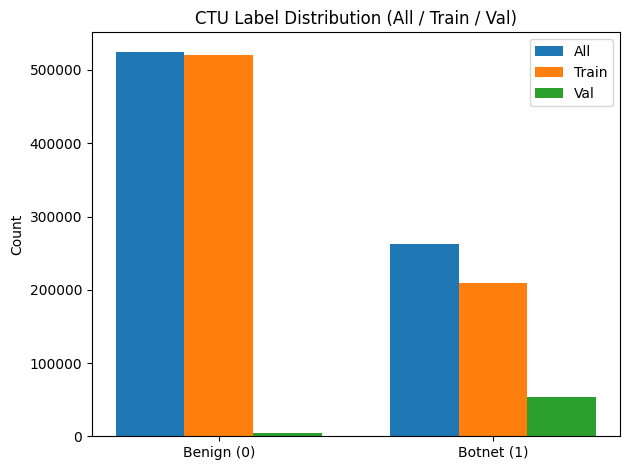

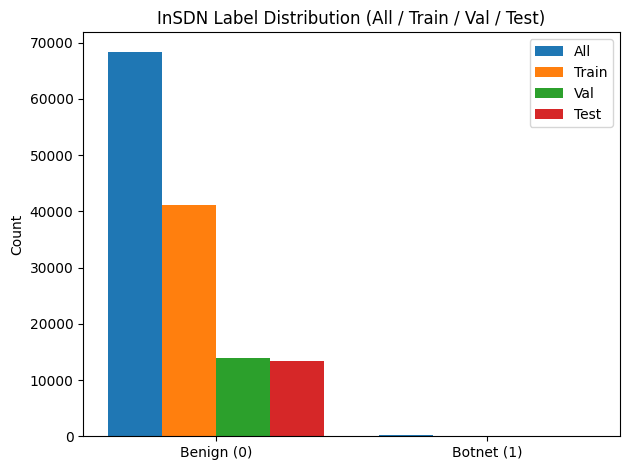


[Plot] CNN_full (InSDN_full) training curves...


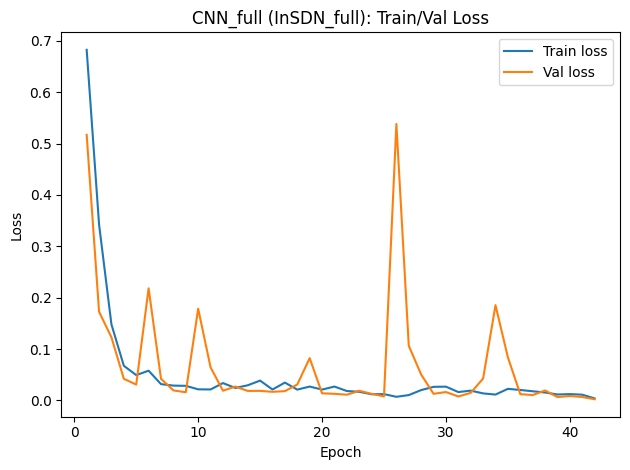

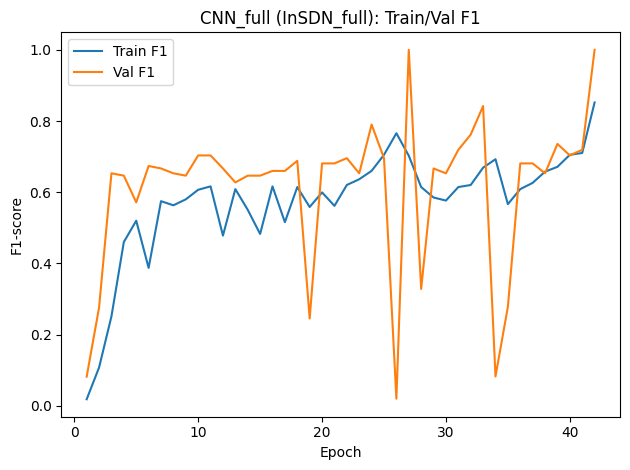


[Plot] CNN_full_10pct (InSDN_full, 10% labels) training curves...


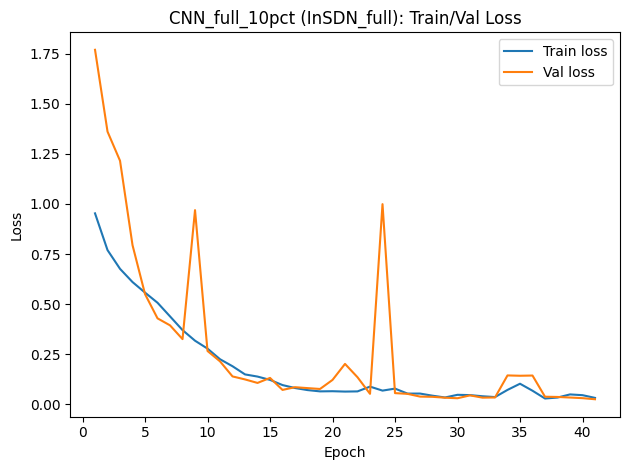

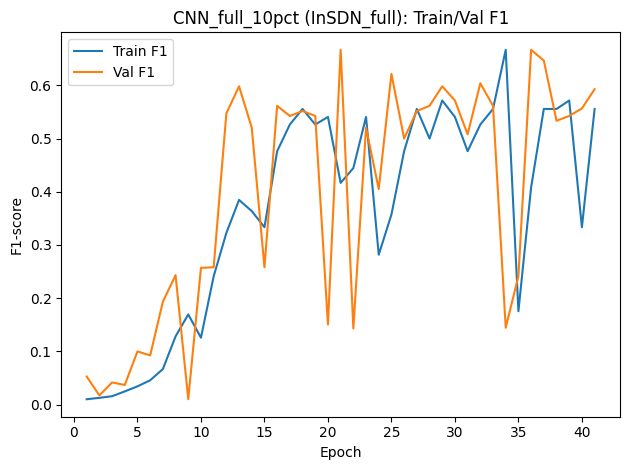


[Plot] CNN_student_PL_10pct training curves...


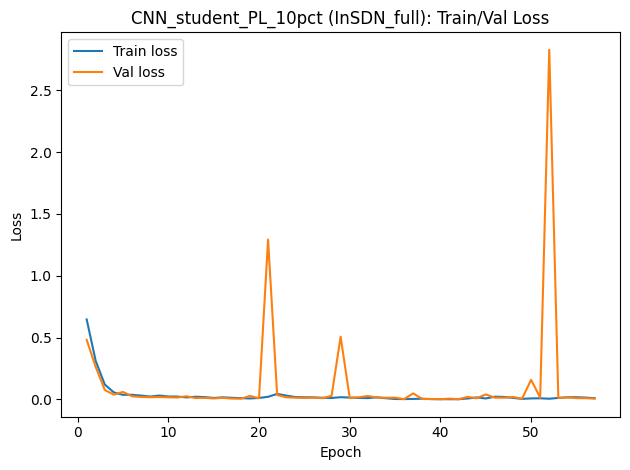

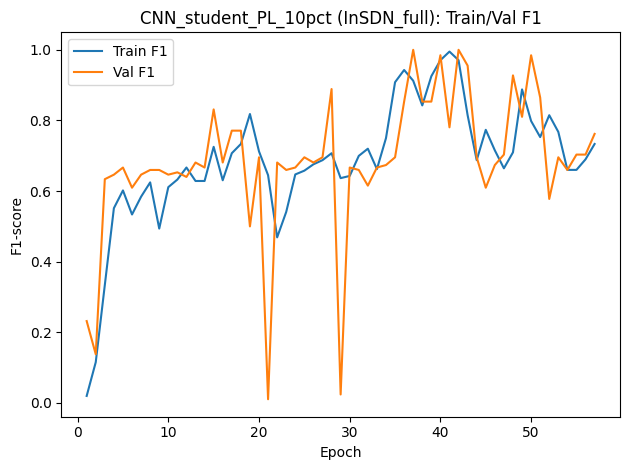

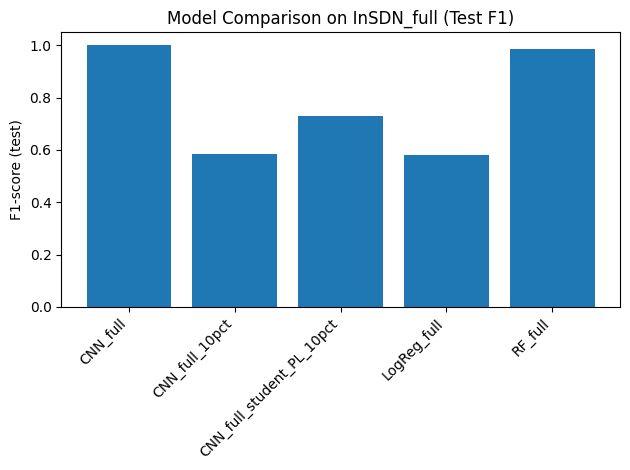

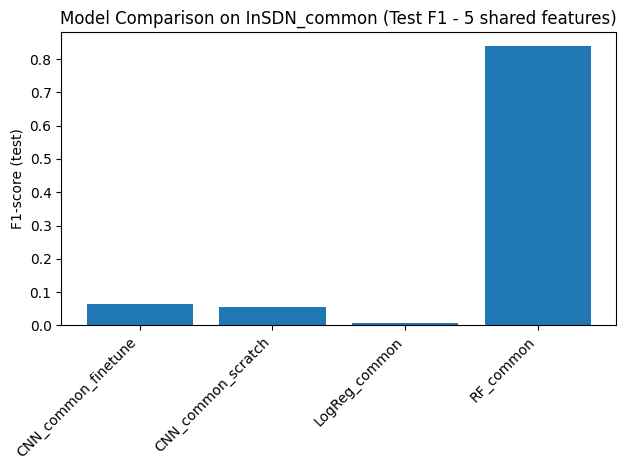


[Plot] ROC and PR curves on InSDN_full test...


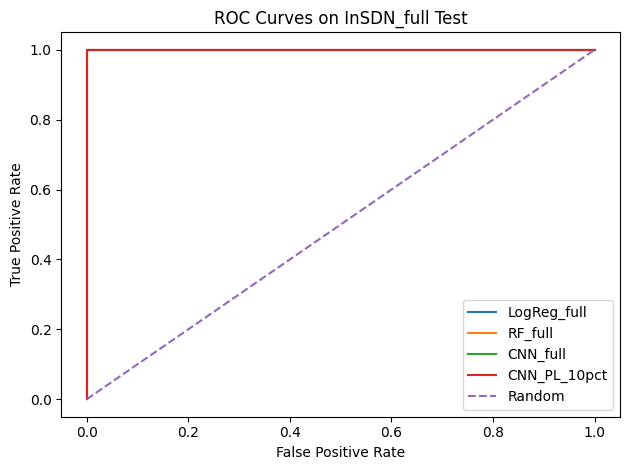

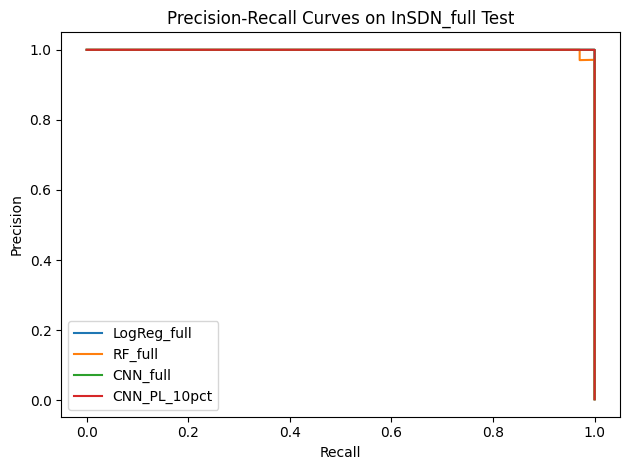


[Done] All requested figures have been generated (if corresponding objects were available).


In [ ]:
# Cell 14: Plot all key figures


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

print("[Step] Plotting figures for the paper...")


# 1) (Class distributions)
# -----------------------------

def plot_label_distribution_ctu():
    """CTU: مقایسه توزیع برچسب‌ها در کل، train، val"""
    if "ctu" not in globals() or "ctu_tr" not in globals() or "ctu_val" not in globals():
        print("[WARN] CTU splits not found. Skipping CTU label distribution.")
        return

    # کل دیتاست
    y_all = ctu[LABEL_COL].values
    y_tr  = ctu_tr[LABEL_COL].values
    y_val = ctu_val[LABEL_COL].values

    counts_all = [(y_all == 0).sum(), (y_all == 1).sum()]
    counts_tr  = [(y_tr  == 0).sum(), (y_tr  == 1).sum()]
    counts_val = [(y_val == 0).sum(), (y_val == 1).sum()]

    labels = ["Benign (0)", "Botnet (1)"]
    x = range(len(labels))

    plt.figure()
    width = 0.25
    plt.bar([p - width for p in x], counts_all, width=width, label="All")
    plt.bar(x,                     counts_tr,  width=width, label="Train")
    plt.bar([p + width for p in x], counts_val, width=width, label="Val")
    plt.xticks(x, labels)
    plt.ylabel("Count")
    plt.title("CTU Label Distribution (All / Train / Val)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_label_distribution_insdn():
    """InSDN: توزیع برچسب‌ها در کل، train، val، test"""
    if "ins" not in globals() or "ins_tr" not in globals() or "ins_val" not in globals() or "ins_test" not in globals():
        print("[WARN] InSDN splits not found. Skipping InSDN label distribution.")
        return

    y_all  = ins[LABEL_COL].values
    y_tr   = ins_tr[LABEL_COL].values
    y_val  = ins_val[LABEL_COL].values
    y_test = ins_test[LABEL_COL].values

    counts_all  = [(y_all == 0).sum(),  (y_all == 1).sum()]
    counts_tr   = [(y_tr  == 0).sum(),  (y_tr  == 1).sum()]
    counts_val  = [(y_val == 0).sum(),  (y_val == 1).sum()]
    counts_test = [(y_test == 0).sum(), (y_test == 1).sum()]

    labels = ["Benign (0)", "Botnet (1)"]
    x = range(len(labels))
    width = 0.2

    plt.figure()
    plt.bar([p - 1.5*width for p in x], counts_all,  width=width, label="All")
    plt.bar([p - 0.5*width for p in x], counts_tr,   width=width, label="Train")
    plt.bar([p + 0.5*width for p in x], counts_val,  width=width, label="Val")
    plt.bar([p + 1.5*width for p in x], counts_test, width=width, label="Test")
    plt.xticks(x, labels)
    plt.ylabel("Count")
    plt.title("InSDN Label Distribution (All / Train / Val / Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_label_distribution_ctu()
plot_label_distribution_insdn()



# 2) (Loss & F1 vs epoch)
# -----------------------------

def plot_cnn_history(history, title_prefix="CNN"):
    """
    history: لیستی از دیکشنری‌ها که در train_torch_model ساخته شده.
    دو نمودار می‌سازد: loss و F1 در طول epoch.
    """
    if not history:
        print(f"[WARN] Empty history for {title_prefix}.")
        return

    epochs     = [h["epoch"] for h in history]
    train_loss = [h["train_loss"] for h in history]
    val_loss   = [h["val_loss"] for h in history]
    train_f1   = [h["train_f1"] for h in history]
    val_f1     = [h["val_f1"] for h in history]

    # Loss
    plt.figure()
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, val_loss,   label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix}: Train/Val Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # F1
    plt.figure()
    plt.plot(epochs, train_f1, label="Train F1")
    plt.plot(epochs, val_f1,   label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title(f"{title_prefix}: Train/Val F1")
    plt.legend()
    plt.tight_layout()
    plt.show()


# CNN_full on InSDN_full
if "CNN_INSDN_FULL_RESULTS" in globals():
    print("\n[Plot] CNN_full (InSDN_full) training curves...")
    plot_cnn_history(CNN_INSDN_FULL_RESULTS["history"], title_prefix="CNN_full (InSDN_full)")

# CNN_full with 10% labels
if "CNN_INSDN_FULL_10PCT_RESULTS" in globals():
    print("\n[Plot] CNN_full_10pct (InSDN_full, 10% labels) training curves...")
    plot_cnn_history(CNN_INSDN_FULL_10PCT_RESULTS["history"], title_prefix="CNN_full_10pct (InSDN_full)")

# Semi-supervised Student (PL 10%)
if "PL_RESULTS_10pct_cnn_full" in globals() and PL_RESULTS_10pct_cnn_full is not None:
    print("\n[Plot] CNN_student_PL_10pct training curves...")
    plot_cnn_history(PL_RESULTS_10pct_cnn_full["history"], title_prefix="CNN_student_PL_10pct (InSDN_full)")


# 3) Compare model F1 scores (bar charts from results_df).
# -----------------------------

if "results_df" in globals() and not results_df.empty:
    # InSDN_full:
    models_full = [
        "LogReg_full",
        "RF_full",
        "CNN_full",
        "CNN_full_10pct",
        "CNN_full_student_PL_10pct",
    ]
    mask_full = (results_df["setting"] == "InSDN_full") & (results_df["split"] == "test") & (results_df["model"].isin(models_full))
    df_full = results_df[mask_full].copy()

    if not df_full.empty:
        plt.figure()
        plt.bar(df_full["model"], df_full["f1"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("F1-score (test)")
        plt.title("Model Comparison on InSDN_full (Test F1)")
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] No InSDN_full test rows found in results_df for selected models.")

    # InSDN_common:
    models_common = [
        "LogReg_common",
        "RF_common",
        "CNN_common_scratch",
        "CNN_common_finetune",
    ]
    mask_common = (results_df["setting"] == "InSDN_common") & (results_df["split"] == "test") & (results_df["model"].isin(models_common))
    df_common = results_df[mask_common].copy()

    if not df_common.empty:
        plt.figure()
        plt.bar(df_common["model"], df_common["f1"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("F1-score (test)")
        plt.title("Model Comparison on InSDN_common (Test F1 - 5 shared features)")
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] No InSDN_common test rows found in results_df for selected models.")
else:
    print("[WARN] results_df not found or empty. Skipping model comparison plots.")



# 4) ROC and PR curves for multiple models on InSDN_full (Test).
# -----------------------------

def get_proba_sklearn(model, X):
    """برگرداندن احتمال کلاس 1 برای مدل‌های sklearn."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        return 1.0 / (1.0 + np.exp(-scores))
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")


def get_proba_torch(model, X, batch_size=2048):
    """برگرداندن احتمال کلاس 1 برای مدل‌های PyTorch."""
    model.eval()
    model.to(DEVICE)

    ds = NumpyTabularDataset(X, np.zeros(X.shape[0], dtype=np.float32))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

    all_logits = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            all_logits.append(logits.detach().cpu())

    all_logits = torch.cat(all_logits, dim=0) if all_logits else torch.empty(0)
    probs = torch.sigmoid(all_logits).numpy()
    return probs


if "y_ins_test" in globals():
    print("\n[Plot] ROC and PR curves on InSDN_full test...")

    y_true_test = y_ins_test

    roc_curves = []
    pr_curves  = []

    # 1) Logistic Regression (full)
    if "logreg_baseline" in globals():
        try:
            proba_logreg = get_proba_sklearn(logreg_baseline, X_ins_test_full_s)
            fpr, tpr, _ = roc_curve(y_true_test, proba_logreg)
            prec, rec, _ = precision_recall_curve(y_true_test, proba_logreg)
            roc_curves.append(("LogReg_full", fpr, tpr))
            pr_curves.append(("LogReg_full", rec, prec))
        except Exception as e:
            print(f"[WARN] Could not compute ROC/PR for LogReg_full: {e}")

    # 2) Random Forest (full)
    if "rf_baseline" in globals():
        try:
            proba_rf = get_proba_sklearn(rf_baseline, X_ins_test_full_s)
            fpr, tpr, _ = roc_curve(y_true_test, proba_rf)
            prec, rec, _ = precision_recall_curve(y_true_test, proba_rf)
            roc_curves.append(("RF_full", fpr, tpr))
            pr_curves.append(("RF_full", rec, prec))
        except Exception as e:
            print(f"[WARN] Could not compute ROC/PR for RF_full: {e}")

    # 3) CNN_full (teacher)
    if "cnn_ins_full" in globals():
        try:
            proba_cnn_full = get_proba_torch(cnn_ins_full, X_ins_test_full_s)
            fpr, tpr, _ = roc_curve(y_true_test, proba_cnn_full)
            prec, rec, _ = precision_recall_curve(y_true_test, proba_cnn_full)
            roc_curves.append(("CNN_full", fpr, tpr))
            pr_curves.append(("CNN_full", rec, prec))
        except Exception as e:
            print(f"[WARN] Could not compute ROC/PR for CNN_full: {e}")

    # 4) CNN_student_PL_10pct
    if "student_cnn_ins_full_semi" in globals() and student_cnn_ins_full_semi is not None:
        try:
            proba_cnn_pl = get_proba_torch(student_cnn_ins_full_semi, X_ins_test_full_s)
            fpr, tpr, _ = roc_curve(y_true_test, proba_cnn_pl)
            prec, rec, _ = precision_recall_curve(y_true_test, proba_cnn_pl)
            roc_curves.append(("CNN_PL_10pct", fpr, tpr))
            pr_curves.append(("CNN_PL_10pct", rec, prec))
        except Exception as e:
            print(f"[WARN] Could not compute ROC/PR for CNN_PL_10pct: {e}")

    # ROC
    if roc_curves:
        plt.figure()
        for name, fpr, tpr in roc_curves:
            plt.plot(fpr, tpr, label=name)
        plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves on InSDN_full Test")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] No ROC curves computed.")

    # PR
    if pr_curves:
        plt.figure()
        for name, rec, prec in pr_curves:
            plt.plot(rec, prec, label=name)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curves on InSDN_full Test")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("[WARN] No PR curves computed.")
else:
    print("[WARN] y_ins_test not found. Skipping ROC/PR plots.")


print("\n[Done] All requested figures have been generated (if corresponding objects were available).")
